In [1]:
library(astsa)
options(repr.plot.width=15, repr.plot.height=8) #ajusta tamaño de graficas
library(dplyr)
#install.packages("xts")                      # Install & load xts package
library("xts")
library(lubridate)
library(forecast) 
#install.packages("fGarch")
library(fGarch)
#install.packages("rugarch")
library(rugarch)
library(tseries)
#install.packages("fDMA")
library(fDMA)
#install.packages("dynlm")
library(dynlm)
#install.packages("FinTS")
library(FinTS)




Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'xts' was built under R version 3.6.3"
Loading required package: zoo

Warning message:
"package 'zoo' was built under R version 3.6.3"

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'xts'


The following objects are masked from 'package:dplyr':

    first, last



Attaching package: 'lubridate'


The following object is masked from 'package:base':

    date


Warning message:
"package 'forecast' was built under R version 3.6.3"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: 'forecast'


The following object is masked from 'package:astsa':

    gas


Warning message:
"package 'fGarch' was built under R versi

# GOLD

In [2]:
df_gold = read.csv("gold_price_data.csv")
head(df_gold,15)
tail(df_gold)

,Date,Value
,<fct>,<dbl>
1,1970-01-01,35.2
2,1970-04-01,35.1
3,1970-07-01,35.4
4,1970-10-01,36.2
5,1971-01-01,37.4
6,1971-04-01,38.9
7,1971-07-01,40.1
8,1971-10-01,42.0
9,1972-01-03,43.5


,Date,Value
,<fct>,<dbl>
10782,2020-03-06,1683.65
10783,2020-03-09,1672.50
10784,2020-03-10,1655.70
10785,2020-03-11,1653.75
10786,2020-03-12,1570.70
10787,2020-03-13,1562.80


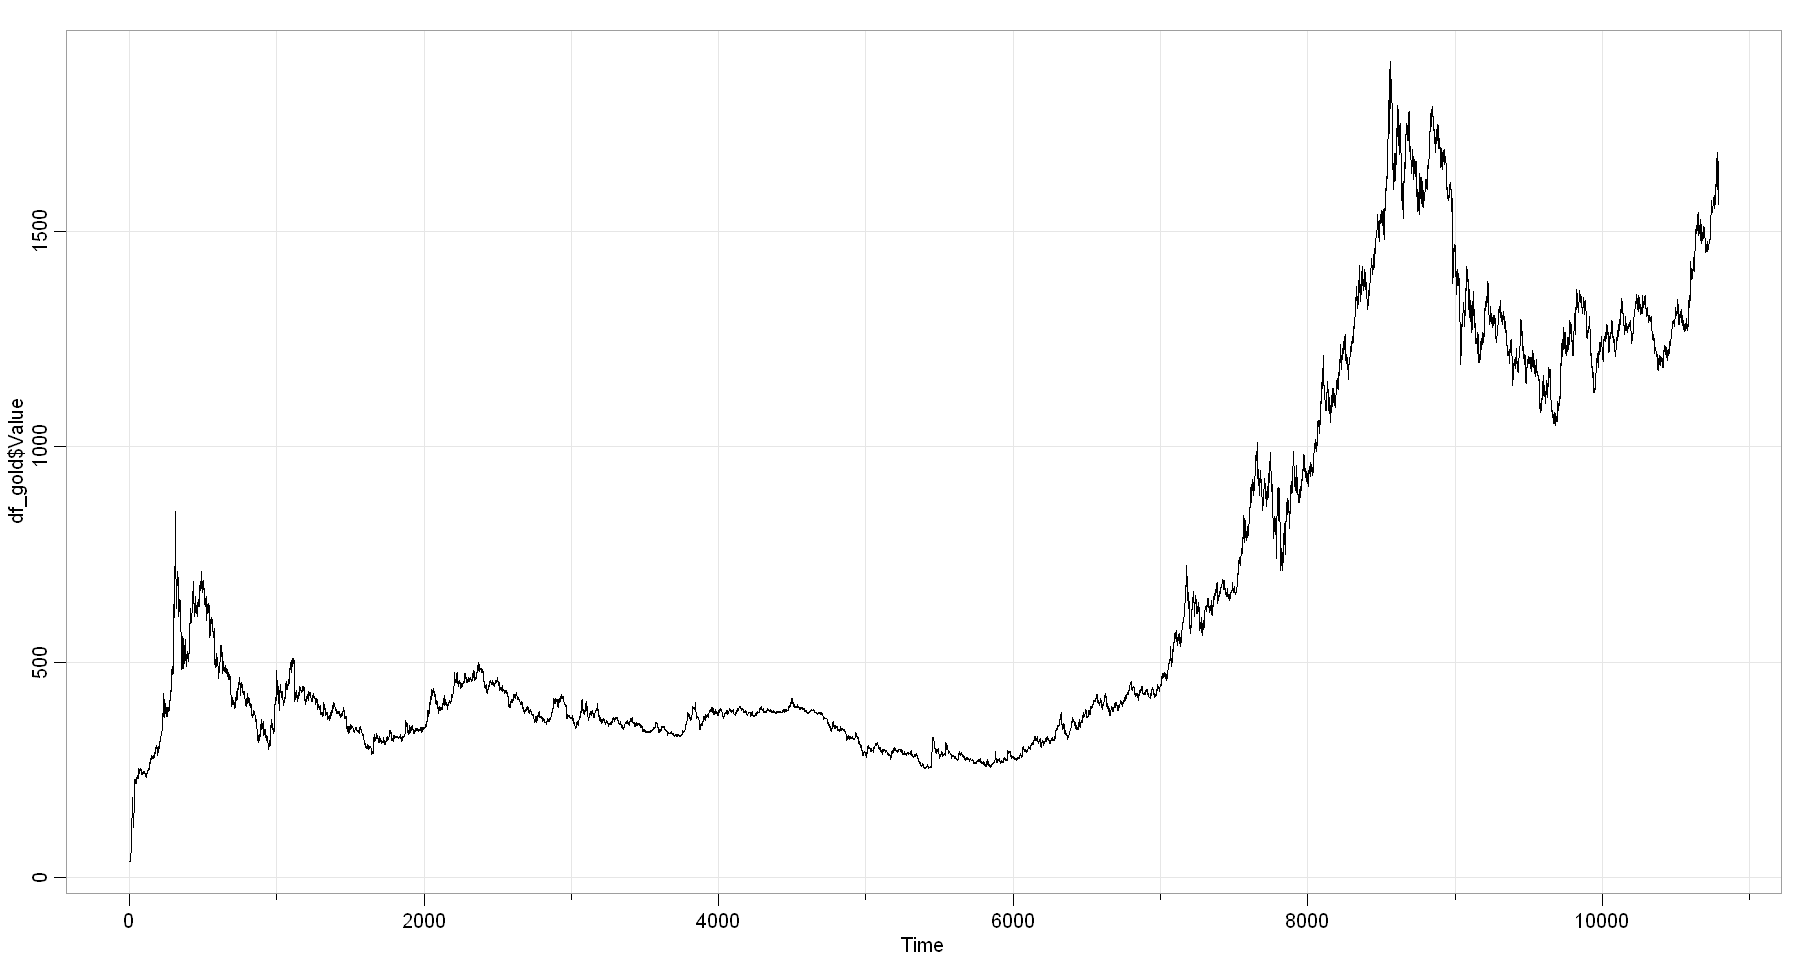

In [3]:
tsplot(df_gold$Value)

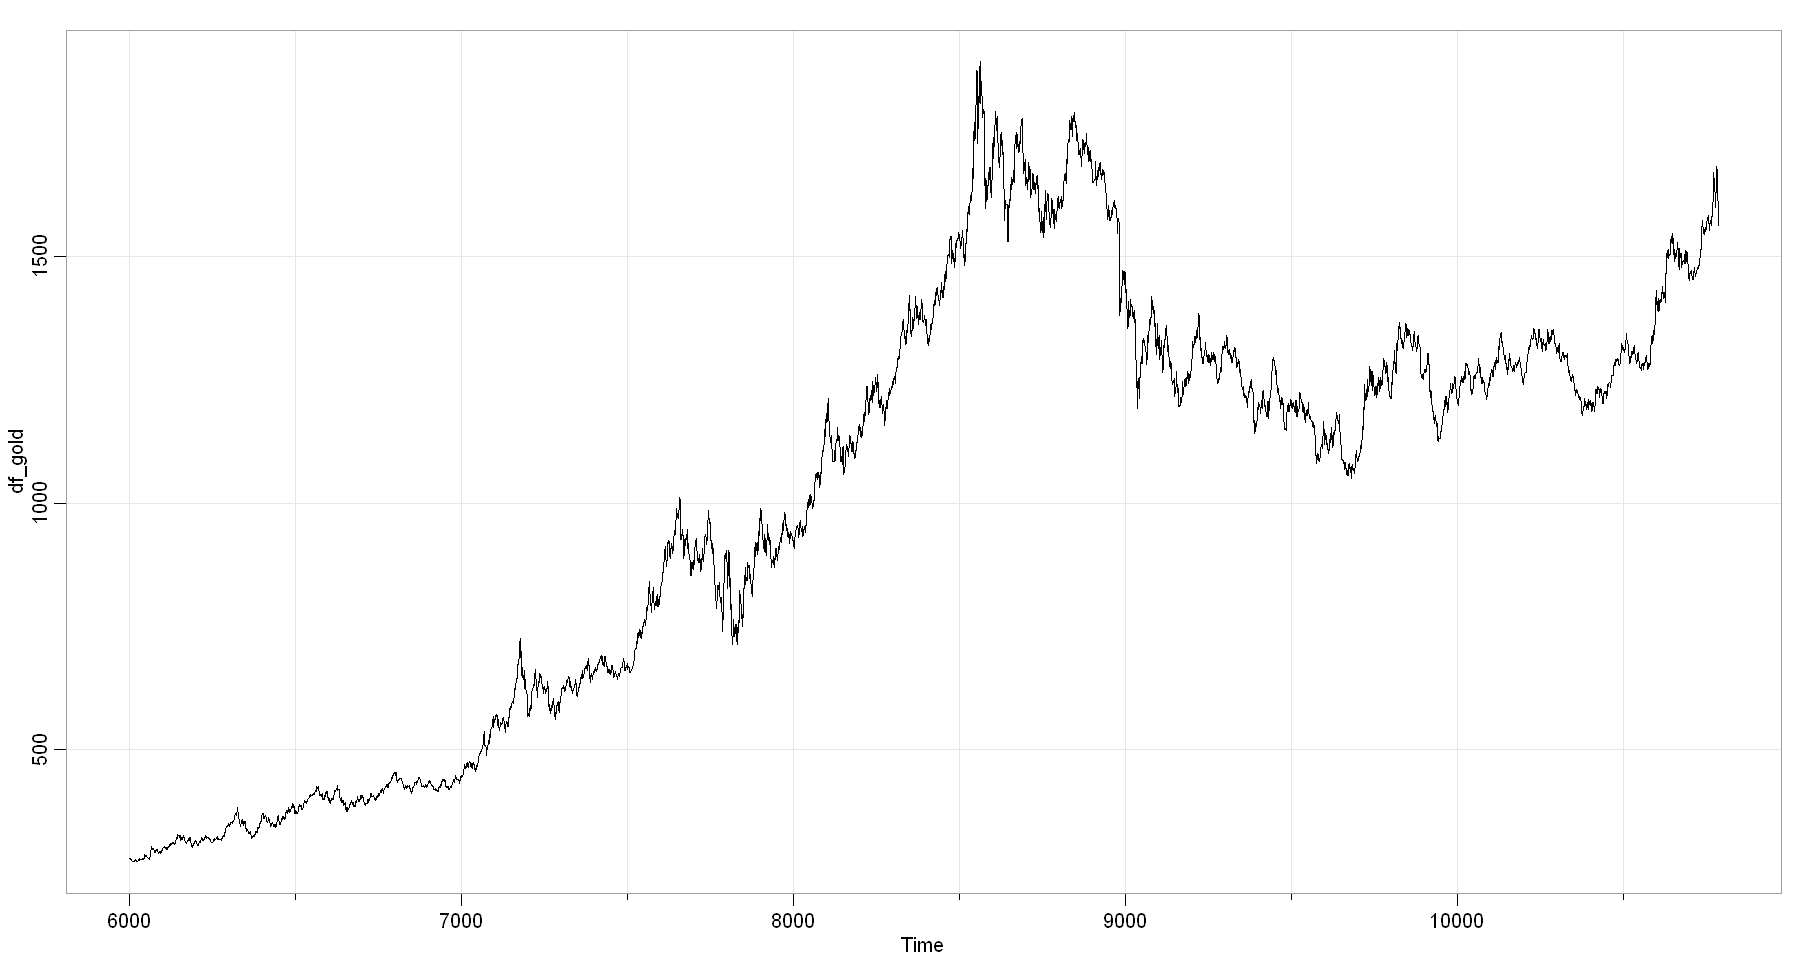

In [4]:
#Reducimos los datos dado que son muchos ya que la señal tienen dos comportamientos diferentes. Nos quedamos con el mas actual que es a partir del dato 6000.
df_gold = ts(df_gold$Value[6000:length(df_gold$Value)],start = 6000)
tsplot(df_gold)

FALTA: EXPLICAR POR QUE CORTAMOS

In [5]:
#Aplico shapiro test para normalidad
shapiro.test(df_gold)
#Nos da que es significativo por lo que rechazo la hipotesis nula de que los datos tiene varianza normal.



	Shapiro-Wilk normality test

data:  df_gold
W = 0.92626, p-value < 2.2e-16


FALTA: EXPLICAR VARIANZA HETEROCEDASTICA

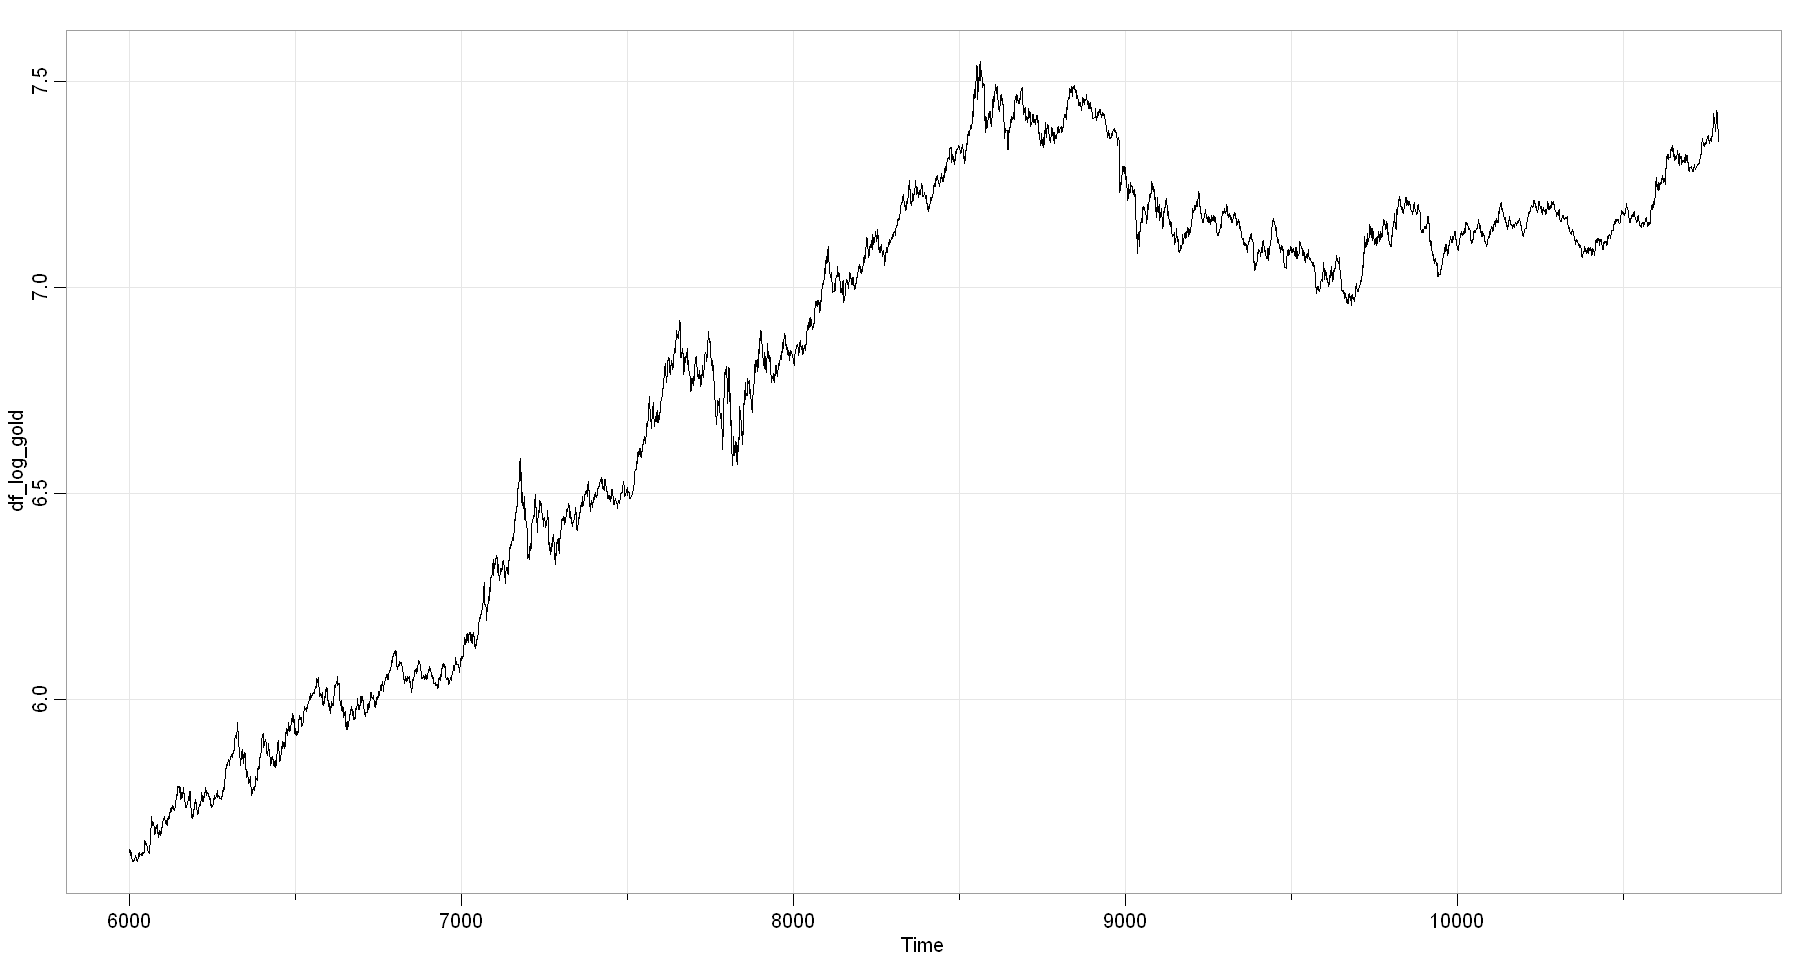

In [6]:
df_log_gold = log(df_gold)
tsplot(df_log_gold)

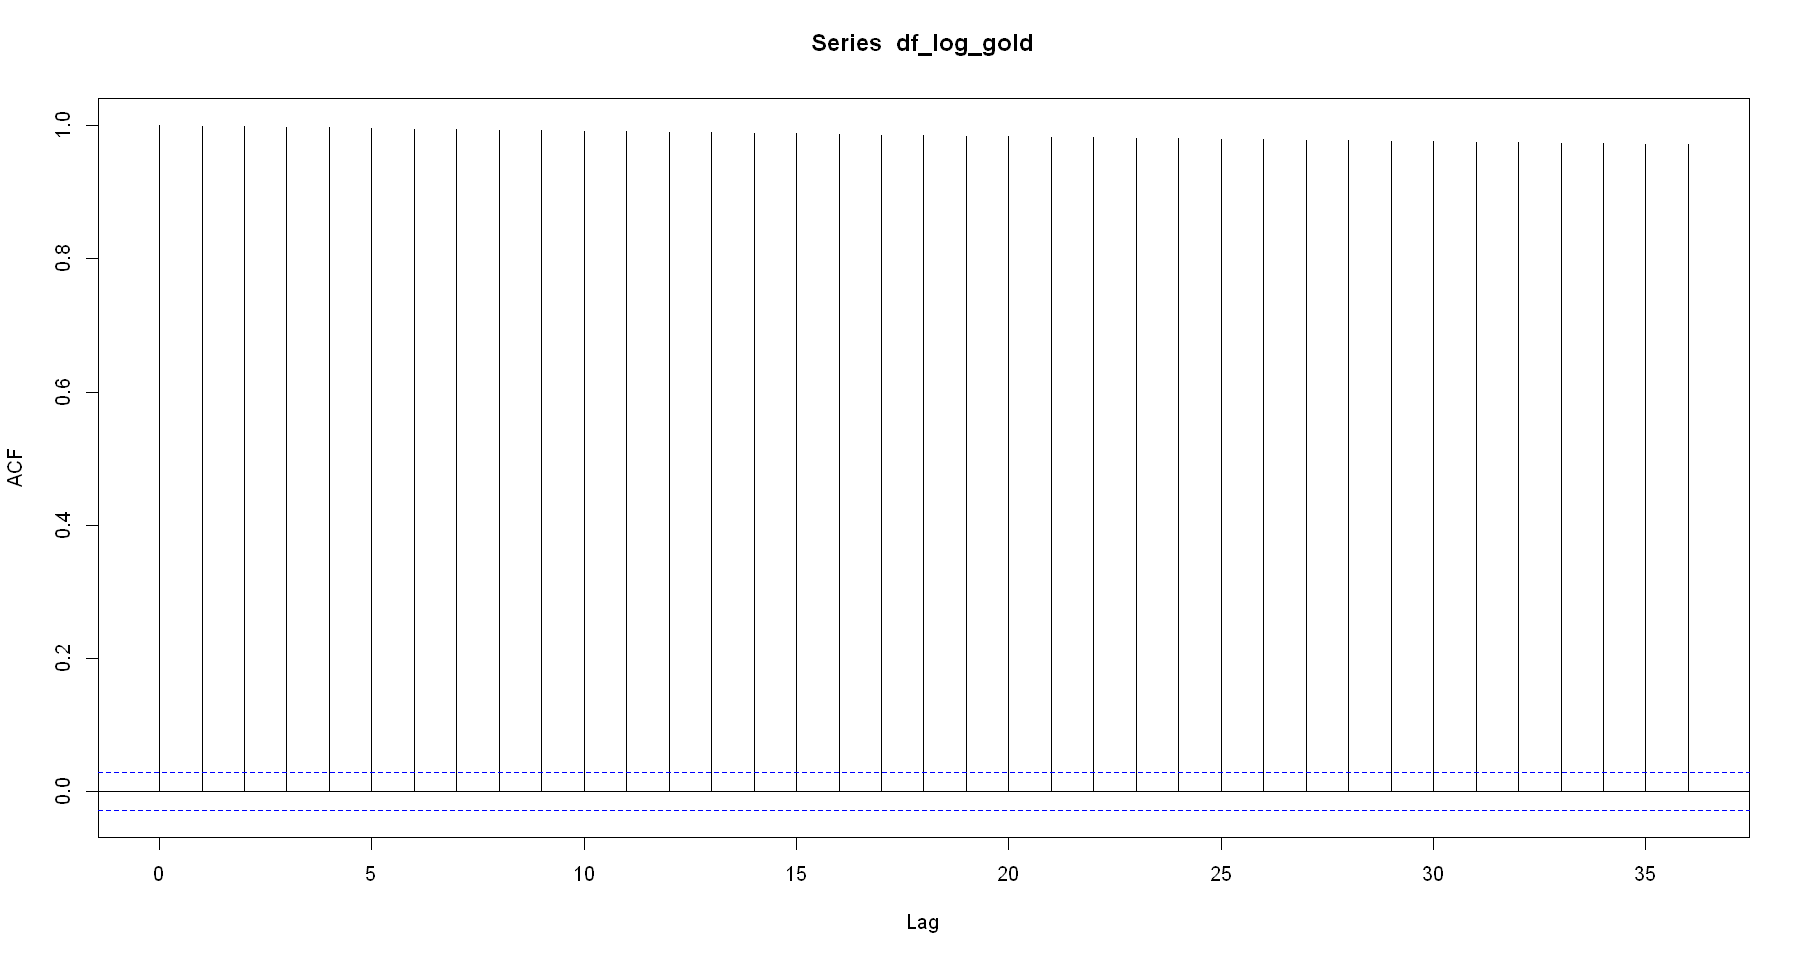

In [7]:
acf(df_log_gold)
#A simple vista ya no es estacionaria , el acf nos demuestra lo mismo que vemos en la grafica del log de gold.

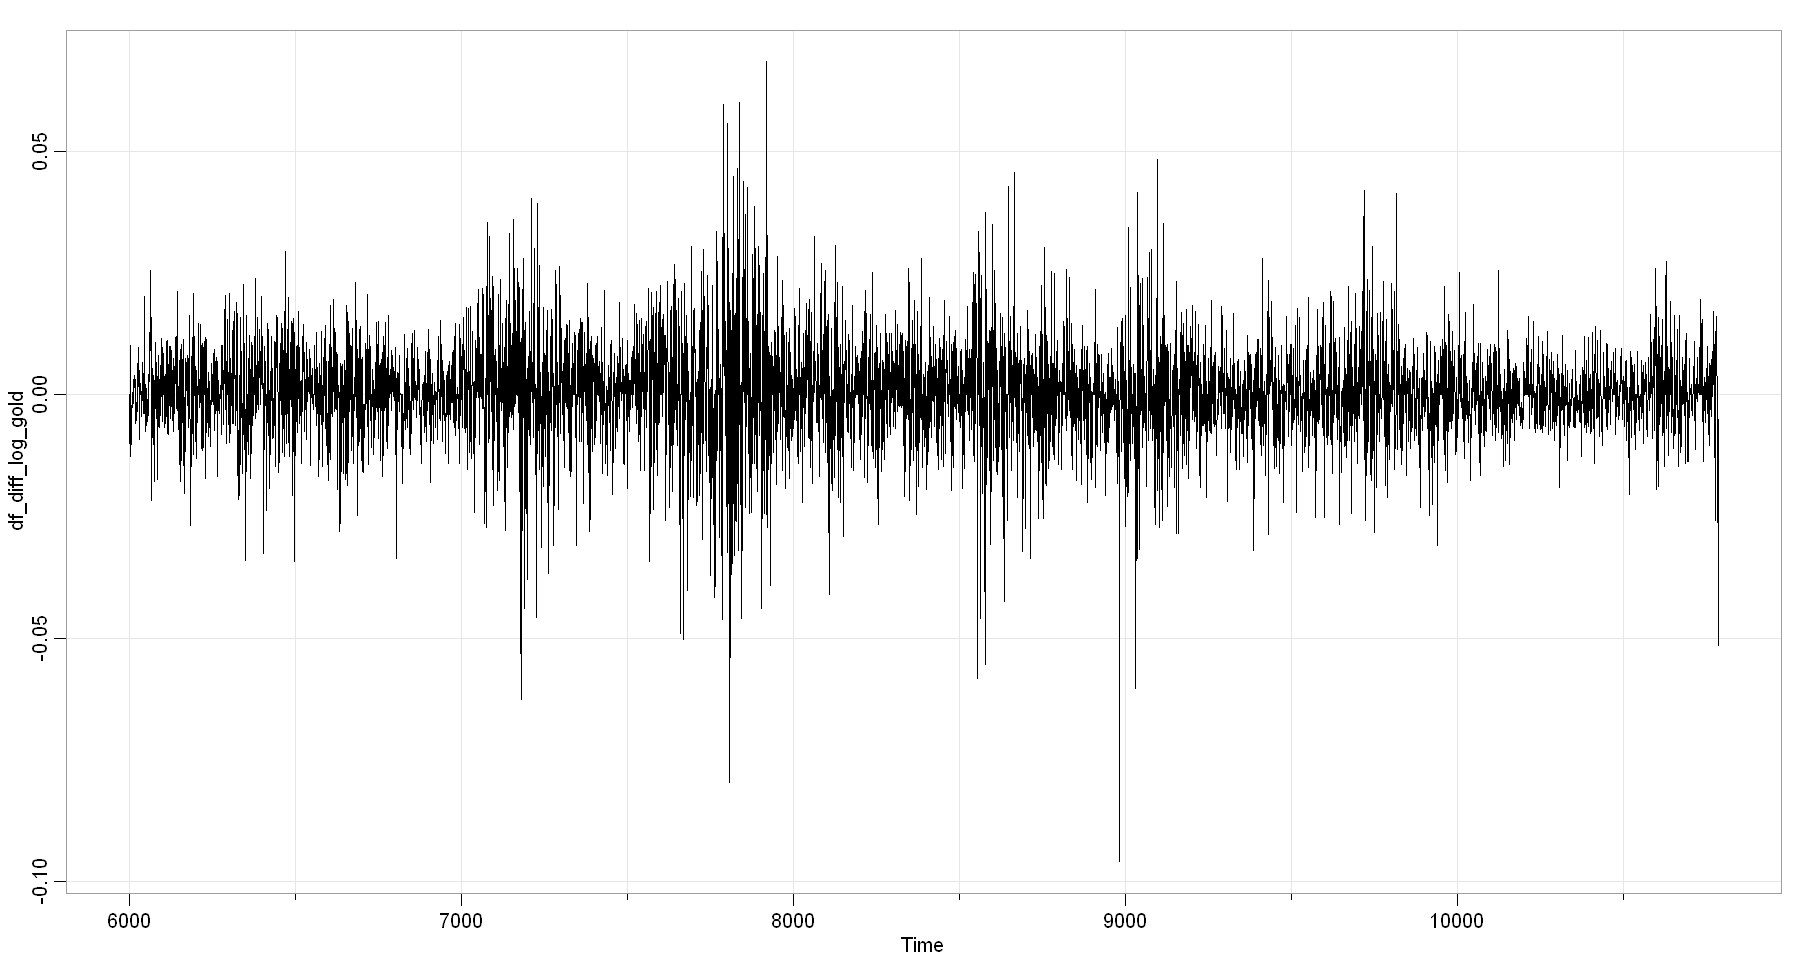

In [8]:
#Como crece año a año aplicamos la diferencia de logaritmos para ver el retorno o tasa de crecimiento.
#Adicionalmente esto permite centrar en cero utilizando esta tecnica en lugar de quitar la tendencia con una recta que no se observa claramente.
#FALTA: Agregar grafico con recta de tendencia para mostrar que no es clara la recta a quitar.
df_diff_log_gold = diff(log(df_gold))
tsplot(df_diff_log_gold)

Observamos que la señal continua teniendo picos marcados (alta varianza) por lo tanto encontramos que es estacionaria en la media con alta varianza.

In [9]:
#Separo train y test en el diff
#Como vamos a intentar predecir el comportamiento de la señal separamos un conjunto de train y test.

train = ts(df_diff_log_gold[0:4740],start = 6001)
test = ts(df_diff_log_gold[4740:length(df_diff_log_gold)],start = 10751)


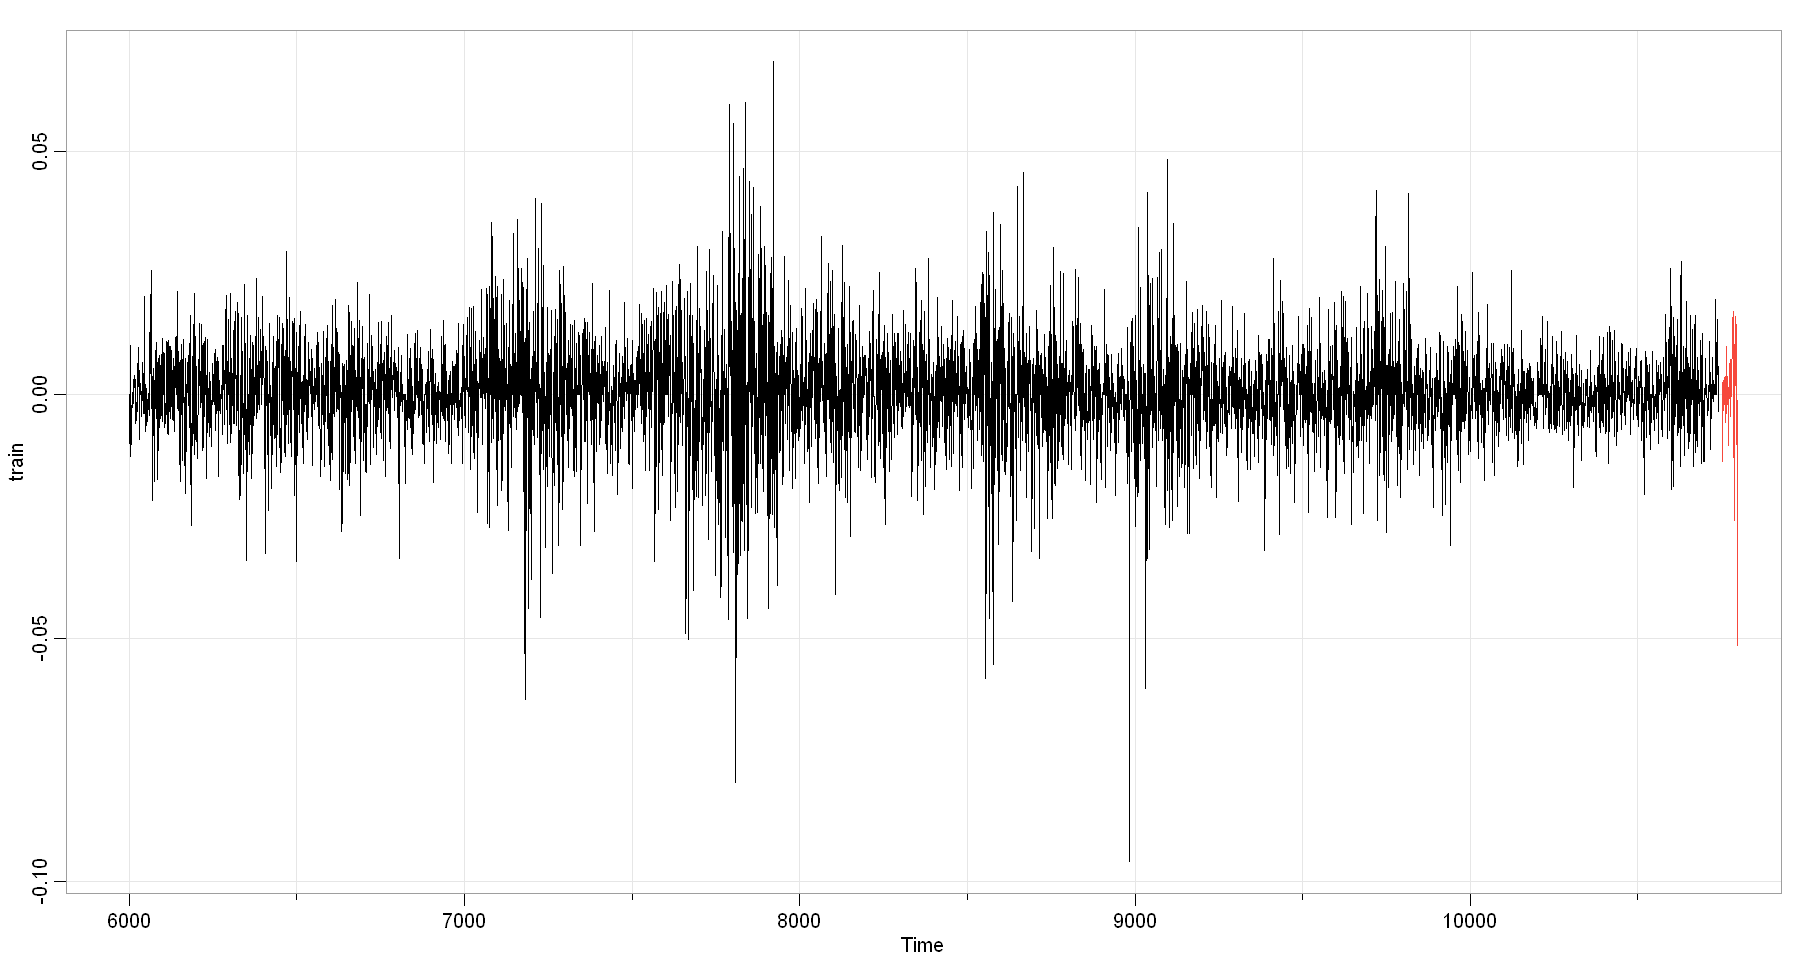

In [10]:
tsplot(train)
lines(test,col=2)

In [11]:
#APlicamos test para confirmar que es estacionario
adf.test(train)
#Rechazamos la hipotesis nula (que no es estacionario) al observar un p-value menor que 0,05 (significativo)

Warning message in adf.test(train):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  train
Dickey-Fuller = -16.863, Lag order = 16, p-value = 0.01
alternative hypothesis: stationary


ACF,0,-0.01,0.01,0.01,0,-0.03,-0.01,-0.01,0.02,-0.02,...,0.02,-0.02,-0.01,-0.04,-0.02,0.01,0.02,-0.01,0.01,-0.01
PACF,0,-0.01,0.01,0.01,0,-0.03,-0.01,-0.01,0.02,-0.02,...,0.02,-0.01,-0.01,-0.04,-0.01,0.01,0.01,0.00,0.00,-0.01


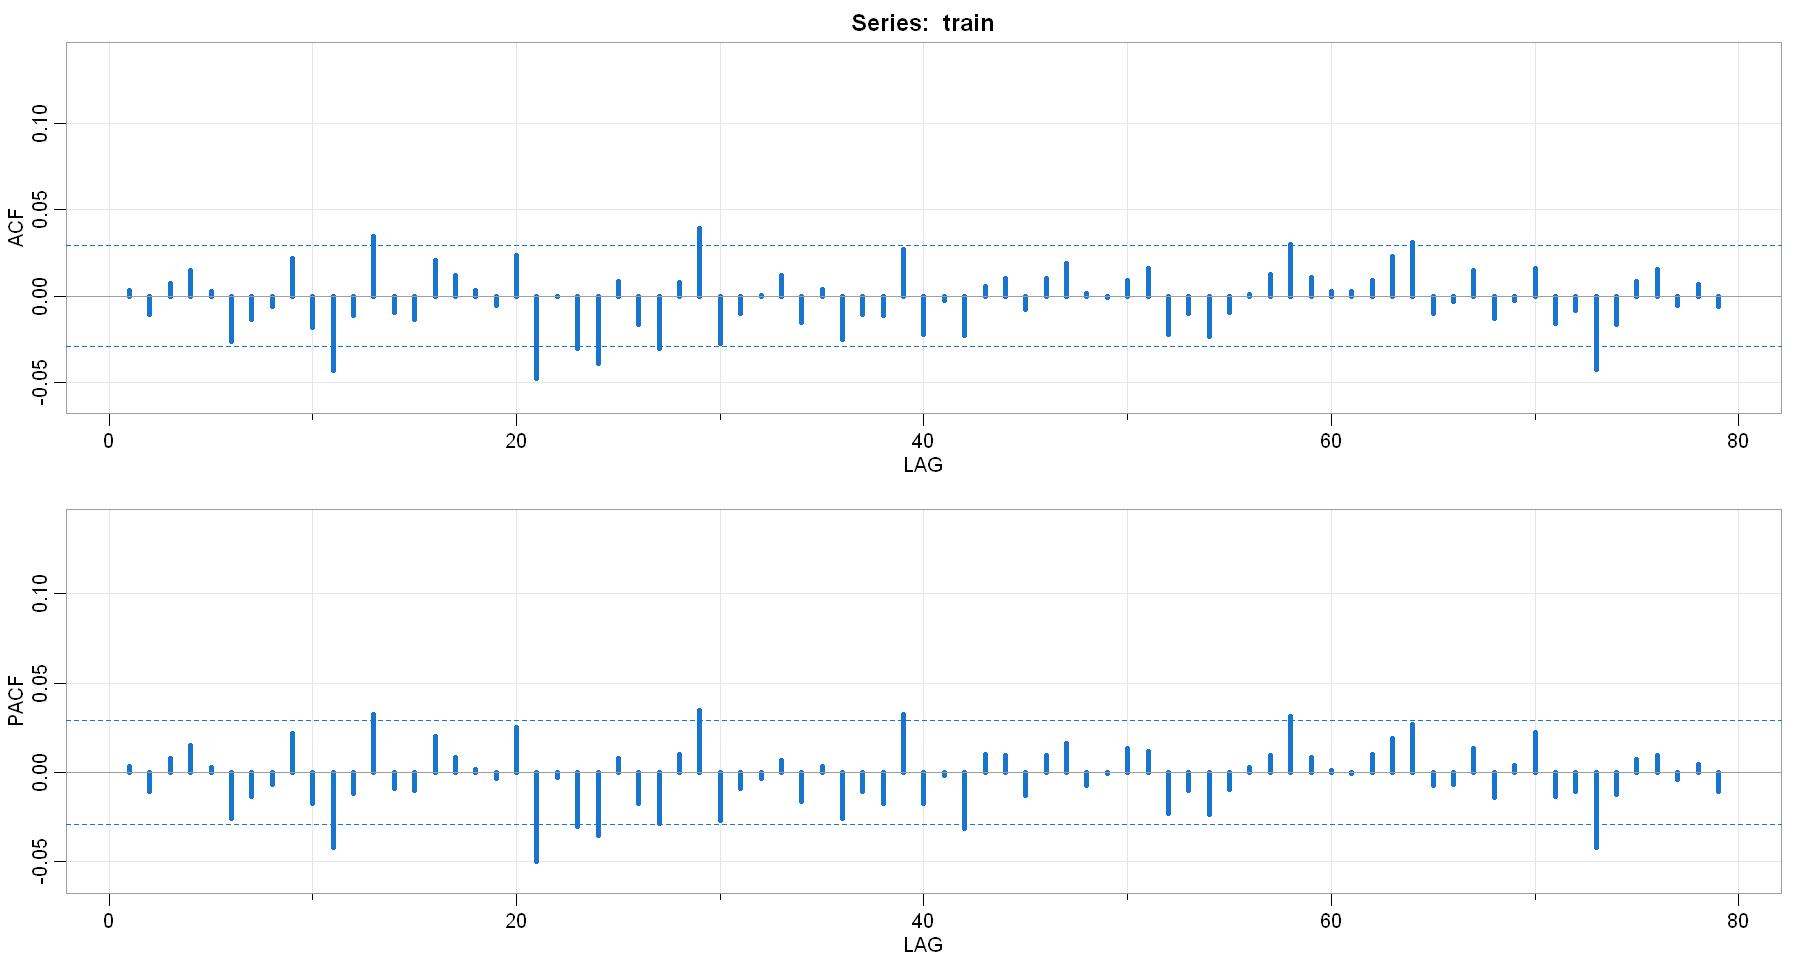

In [12]:
acf2(train, lwd=4, col=4)
#No encontramos ningun componente media movil el ACF , ni autorregresivo en el PACF.
#Si bien en el PACF encontramos algunas barras muy pequeñas fuera del intervalo de confianza entendemos que son parte del 5% de error.
#Ya que anteriormente habiamos aplicado diff y ahora nos da ruido blanco es que estamos en presencia de un paseo al azar con deriva.

In [13]:
#El auto arima de R concluye lo mismo que nosotros
auto.arima(train)

Series: train 
ARIMA(0,0,0) with non-zero mean 

Coefficients:
       mean
      4e-04
s.e.  2e-04

sigma^2 estimated as 0.0001165:  log likelihood=14741.24
AIC=-29478.47   AICc=-29478.47   BIC=-29465.54

Descartamos la posibilidad de utilizar un modelo ARIMA ya que como vimos anteriormente estamos en presencia de una señal que si bien estacionaria en la media, no tiene varianza constante y esto contradice un supuesto fundamental para la apliciacion de los modelos ARIMA que deben tener estacionalidad en la media y varianza constante.

A continuacion, analizaremos el comportamiento de la varianza.

# Analisis de varianza

[1] 0.01079364

[1] 0.0001165026

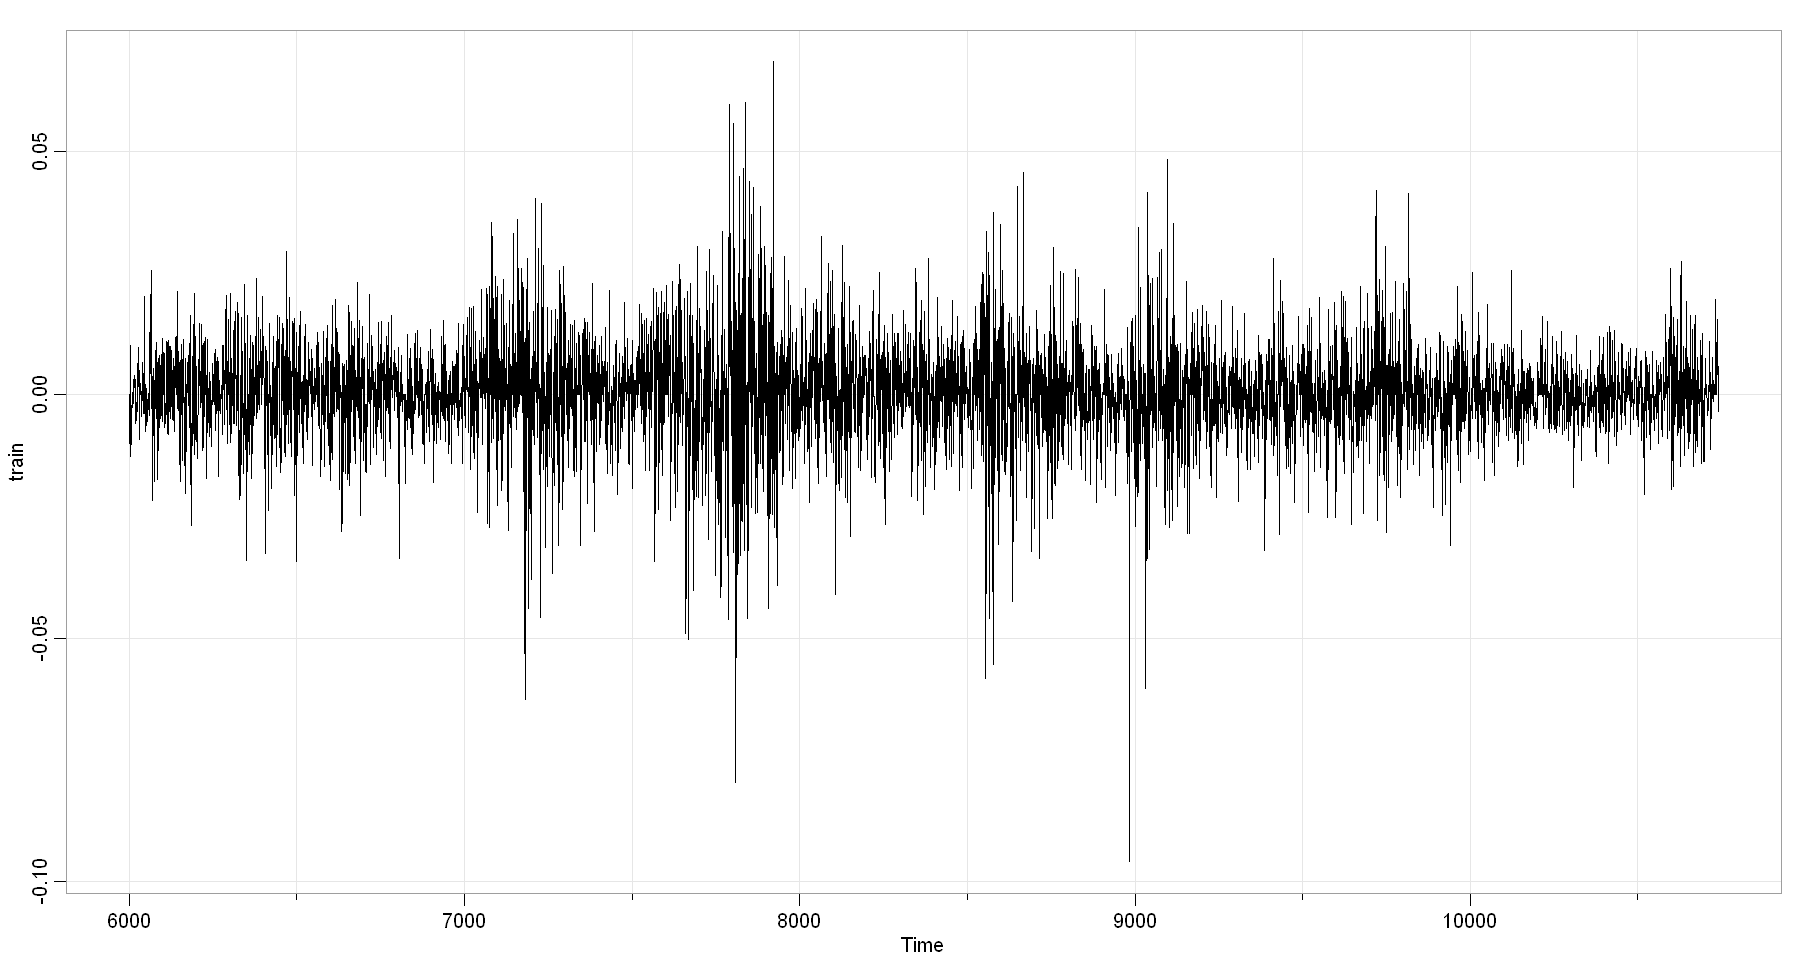

In [14]:
sd(train)
var(train)
tsplot(train)

In [15]:
vent<- 50
vent2<- vent-1


varianza=c()
for(i in vent:length(train))
    {f=var(train[(i-vent2):i])
    varianza[i]=(f)}



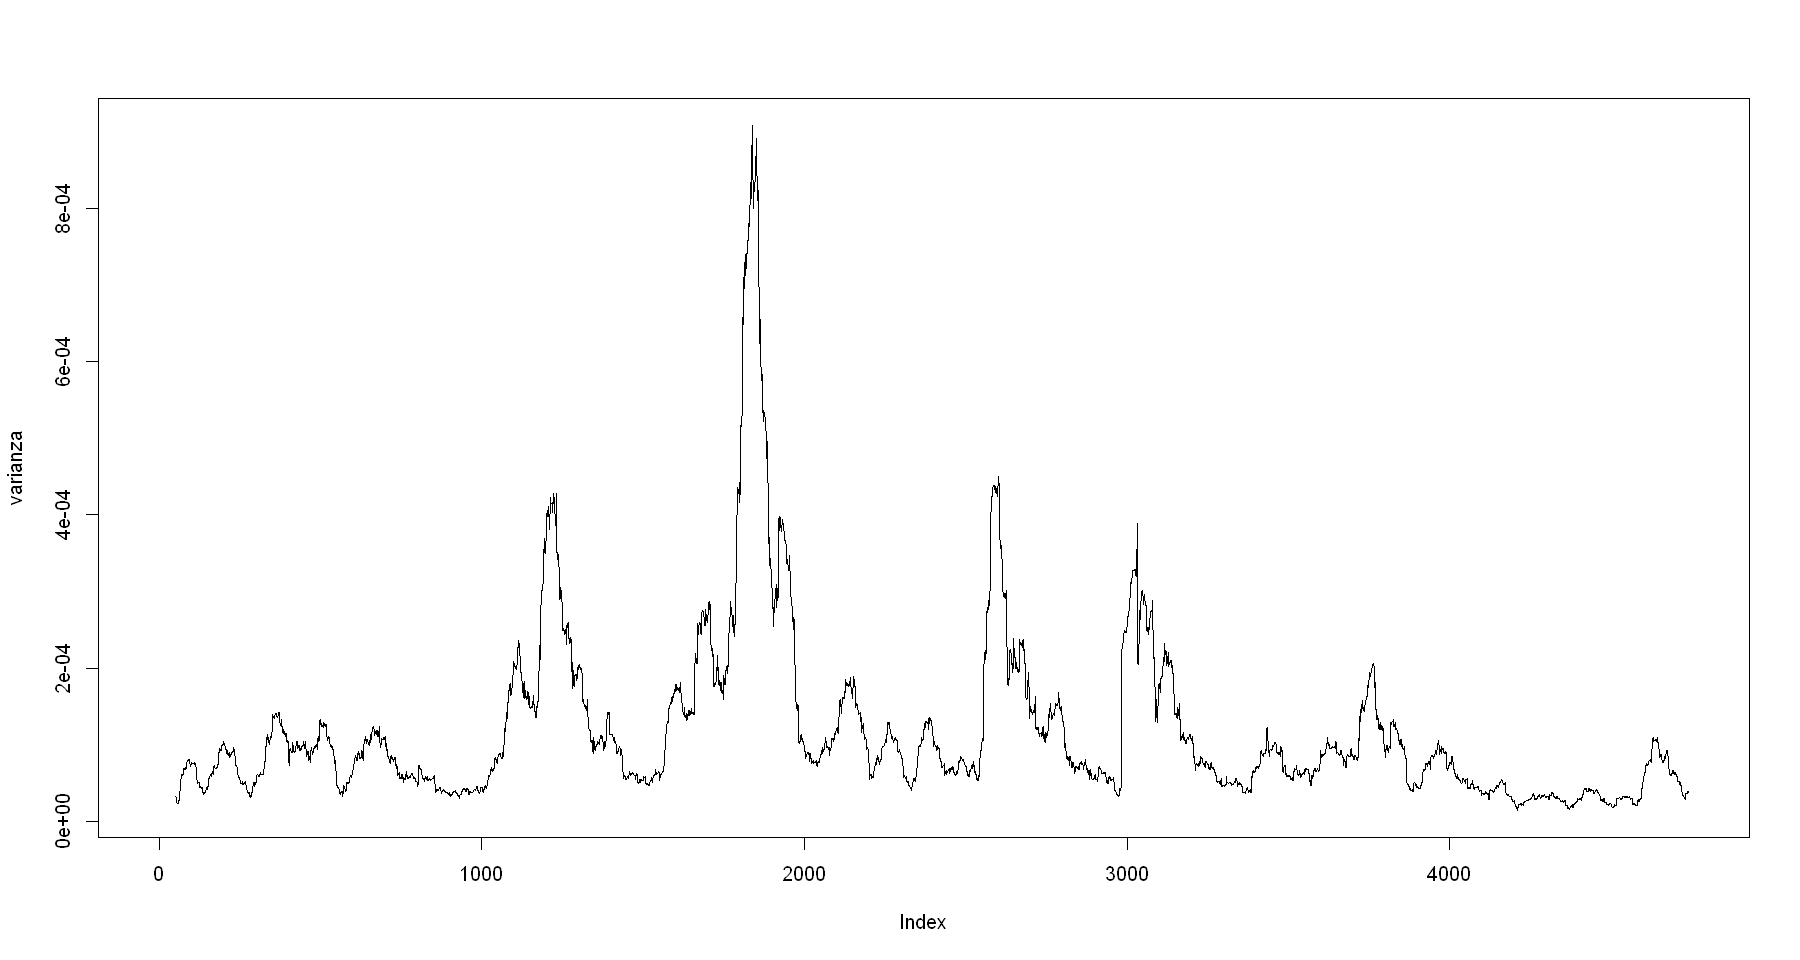

In [16]:
plot(varianza,type="l")

Se puede observar como mirando en distintas ventanas de tiempo la varianza no es constante.

In [17]:
y<-train

In [18]:
STDM=c()
for(i in vent:length(y))
    {f=sd(y[(i-vent2):i])
    STDM[i]=(f)}
#STDM
STDM2<-STDM*2

In [19]:
MM=c()
for(i in vent:length(y))
    {f=mean(y[(i-vent2):i])
    MM[i]=(f)}

In [20]:
#desviacion típica

#sd(na.omit(y))
#2*sd(na.omit(y))

sd1= MM + STDM
#sd1
sd11= MM-STDM
#sd11

In [21]:
sd2<-MM+STDM2
sd22<-MM-STDM2

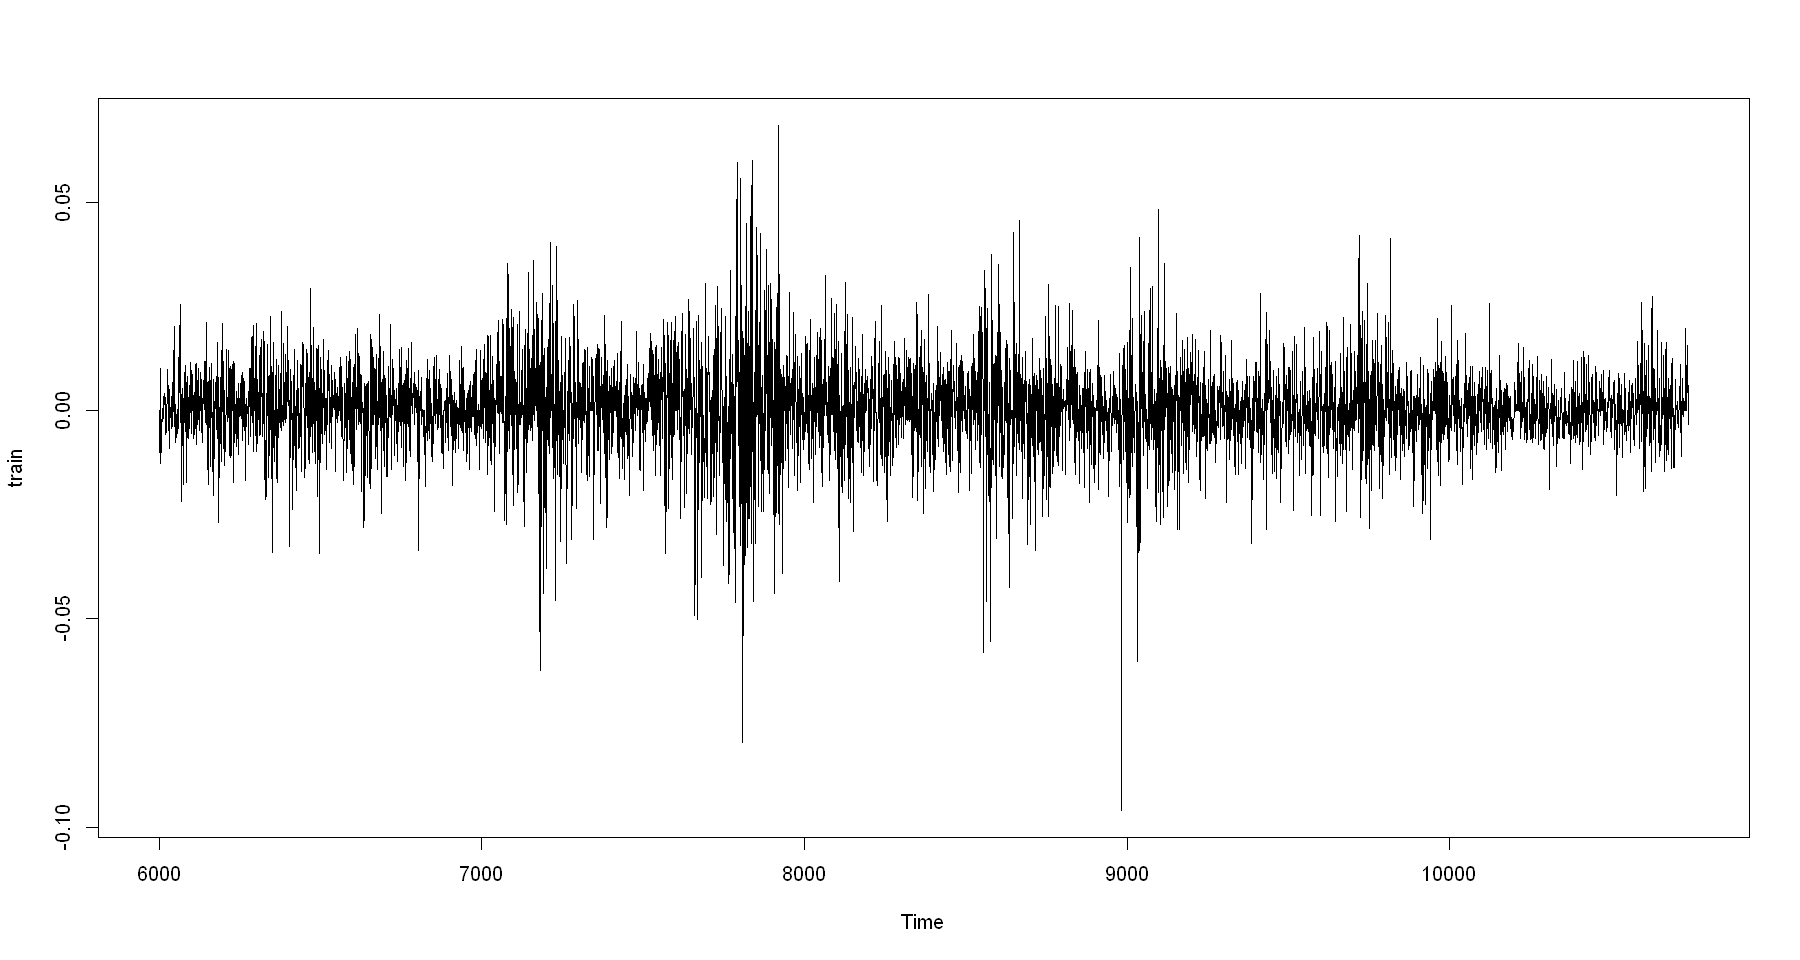

In [22]:
plot(train,type="l")
lines(MM, col="blue")
lines(sd11, col="green")
lines(sd1,col="green")
lines(sd2,col="red")
lines(sd22,col="red")

In [23]:
#Se muestra como la varianza no es constante.

#FALTA:NOI ESTAN FUNCIONANDO LOS COLORES. EXPLICAR COLORES.

Debido a esto es que podemos pensar en la aplicacion de un modelo ARCH o GARCH. Vamos a confirmarlo a travez de un ARCH test.

Para saber si los residuos tienen alta varianza vamos a aplicar una prueba ARCH (ARCH test).

FALTA ESCRIBIR LA HIPOTESIS NULA

La prueba de efecto ARCH es una prueba de ruido blanco para la serie de tiempo al cuadrado, en nuestro caso serian la señal al cuadrado. Lo que en otras palabras es la investigacion de un orden superior no lineal de autocorrelacion.

Por ende una prueba ARCH significativa nos indica una volatilidad variable en el tiempo.



In [24]:
#Hacemos teste de aplicacion de arch
archtest = archtest(ts = as.vector(train))
archtest


	Engle's LM ARCH Test

data:  as.vector(train)
statistic = 38.623, lag = 1, p-value = 5.142e-10
alternative hypothesis: ARCH effects of order 1 are present


In [25]:
#Hacemos teste de aplicacion de archnde orden 2
archtest = archtest(ts = as.vector(train),lag = 2)
archtest


	Engle's LM ARCH Test

data:  as.vector(train)
statistic = 76.358, lag = 2, p-value < 2.2e-16
alternative hypothesis: ARCH effects of order 2 are present


In [26]:
#Hacemos teste de aplicacion de archnde orden 50
archtest = archtest(ts = as.vector(train),lag = 50)
archtest


	Engle's LM ARCH Test

data:  as.vector(train)
statistic = 536.42, lag = 50, p-value < 2.2e-16
alternative hypothesis: ARCH effects of order 50 are present


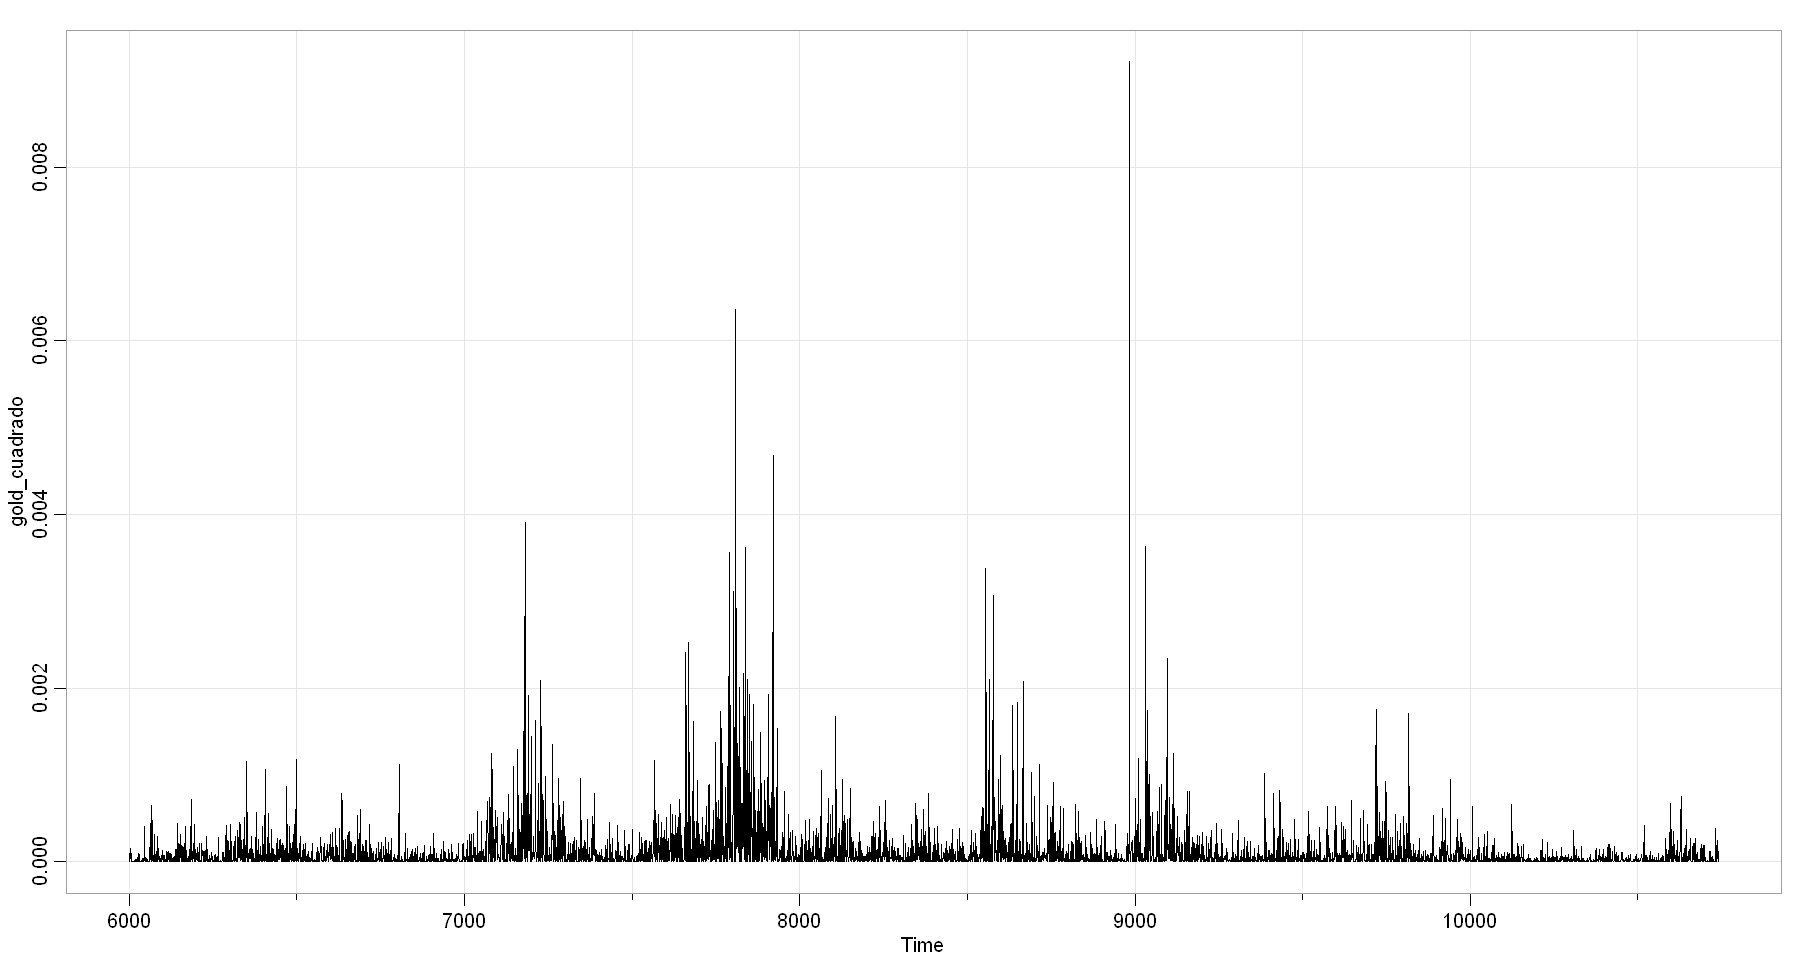

In [27]:

gold_cuadrado = train^2
tsplot(gold_cuadrado)
#Se muestra como hay varianza es heterosedastica por que es muy variable en el tiempo.

## Orden ARCH

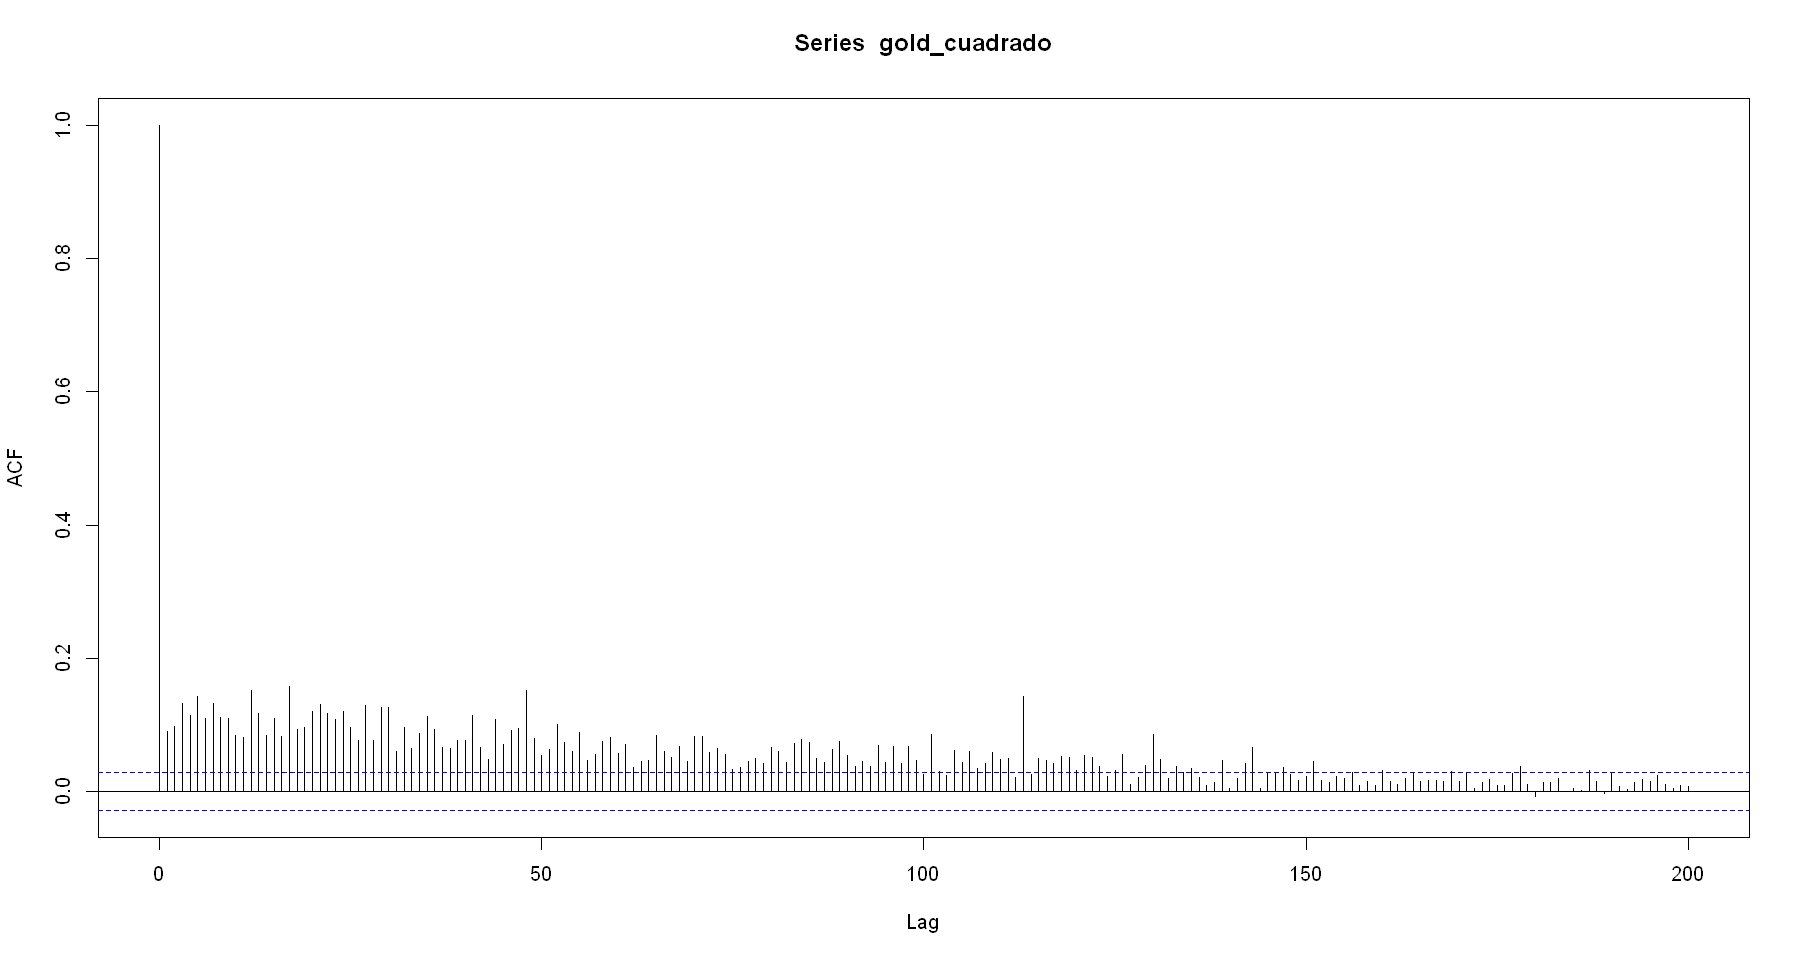

In [28]:
acf(gold_cuadrado,lag.max = 200)

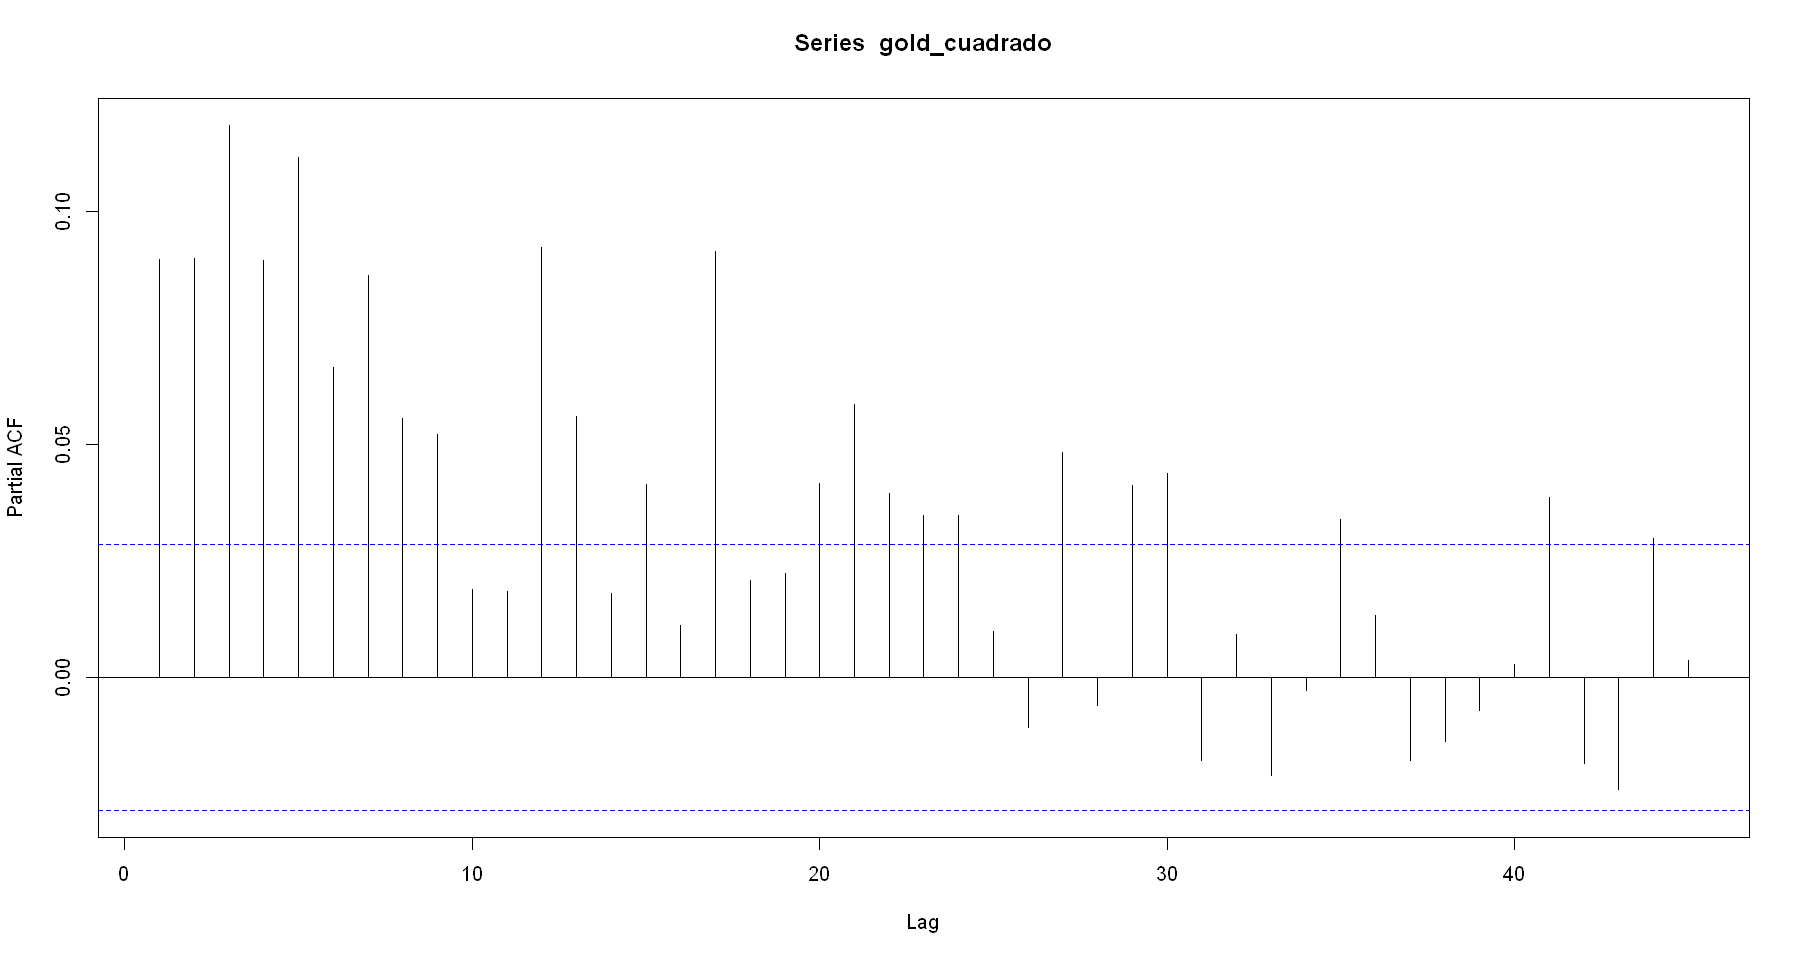

In [29]:
pacf(gold_cuadrado,lag.max = 45)

En funcion del PACF optamos por un orden de 7 para la obtencion de un modelo ARCH en nuestra señal. Al ejecutarlo tuvimos un problema de convergencia por lo que aumentamos el orden a 9.

Si bien mas alla del lag 10 existen algunas barras por arriba de las intervalos de confianza , entendemos que con esta seleccion se capturara correctamente la varianza del modelo.

# Aplicamos ARCH

Comenzamos por aplicar un modelo basico como es el ARCH.

Este tipo de modelo es similar al autoregresivo, con la diferencia de que usa la varianza lageada.

FALTA: formula ARCH

In [30]:
gold_arch9_spec <-  ugarchspec(variance.model = list(model="sGARCH",         #Other options are egarch, fgarch, etc.
                                                     garchOrder=c(9,0)), # You can modify the order GARCH(m,s) here
                               mean.model = list(armaOrder = c(0, 0), include.mean = TRUE, archm = FALSE, archpow = 1, arfima = FALSE, external.regressors = NULL, archex = FALSE),
                                distribution.model = "norm")         #Other distribution are "std" for t-distribution, and "ged" for General Error Distribution
gold_arch9 <- ugarchfit(spec=gold_arch9_spec, 
                              data=train)


In [31]:
gold_arch9


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(9,0)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000332    0.000131   2.5374 0.011168
omega   0.000037    0.000003  14.0724 0.000000
alpha1  0.026989    0.011947   2.2590 0.023881
alpha2  0.069809    0.016245   4.2973 0.000017
alpha3  0.079209    0.015652   5.0607 0.000000
alpha4  0.106514    0.017680   6.0247 0.000000
alpha5  0.074648    0.015738   4.7432 0.000002
alpha6  0.069897    0.017525   3.9884 0.000067
alpha7  0.132438    0.020189   6.5598 0.000000
alpha8  0.057246    0.015654   3.6569 0.000255
alpha9  0.104588    0.019177   5.4539 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000332    0.000147   2.2679 0.023336
omega   

# Aplicamos GARCH

Aplicamos un modelo GARCH.

Este tipo de modelo es similar al de media movil, con la diferencia de que usa el error de la varianza en la ecuacion.

FALTA: formula GARCH

In [32]:
gold_garch99_spec <-  ugarchspec(variance.model = list(model="sGARCH",         #Other options are egarch, fgarch, etc.
                                                     garchOrder=c(9,9)), # You can modify the order GARCH(m,s) here
                               #mean.model = list(armaOrder=c(1,2)), #Specify your ARMA model implying your model should be stationary.
                               mean.model = list(armaOrder = c(0, 0), include.mean = TRUE, archm = FALSE, archpow = 1, arfima = FALSE, external.regressors = NULL, archex = FALSE),
                                distribution.model = "norm")         #Other distribution are "std" for t-distribution, and "ged" for General Error Distribution
gold_garch99 <- ugarchfit(spec=gold_garch99_spec, 
                              data=train)


In [33]:
gold_garch99


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(9,9)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000288    0.000128 2.261294 0.023741
omega   0.000004    0.000001 3.074121 0.002111
alpha1  0.035742    0.016893 2.115777 0.034364
alpha2  0.011413    0.049618 0.230015 0.818080
alpha3  0.043305    0.013099 3.305986 0.000946
alpha4  0.034881    0.019655 1.774713 0.075945
alpha5  0.008804    0.008245 1.067856 0.285585
alpha6  0.032254    0.025735 1.253308 0.210094
alpha7  0.083603    0.040940 2.042081 0.041143
alpha8  0.006607    0.035513 0.186046 0.852408
alpha9  0.038913    0.068709 0.566352 0.571155
beta1   0.000001    1.008199 0.000001 1.000000
beta2   0.000000    0.607405 0.000001 0.999999
beta3   0.000000    0.662817 0.00

# egarch (1,1)

FALTA: formula EGARCH

In [34]:
gold_egarch11_spec <-  ugarchspec(variance.model = list(model="eGARCH",         #Other options are egarch, fgarch, etc.
                                                     garchOrder=c(1,1)), # You can modify the order GARCH(m,s) here
                               mean.model = list(armaOrder=c(0,0)), #Specify your ARMA model implying your model should be stationary.
                               distribution.model = "norm")         #Other distribution are "std" for t-distribution, and "ged" for General Error Distribution
gold_egarch11 <- ugarchfit(spec=gold_egarch11_spec, 
                              data=train)

In [35]:
gold_egarch11


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000437    0.000126    3.4691 0.000522
omega  -0.056711    0.001371  -41.3515 0.000000
alpha1  0.007693    0.004957    1.5519 0.120679
beta1   0.993106    0.000122 8150.8229 0.000000
gamma1  0.098242    0.003968   24.7614 0.000000

Robust Standard Errors:
        Estimate  Std. Error    t value Pr(>|t|)
mu      0.000437    0.000134    3.26897 0.001079
omega  -0.056711    0.002328  -24.36458 0.000000
alpha1  0.007693    0.013373    0.57521 0.565147
beta1   0.993106    0.000249 3986.83808 0.000000
gamma1  0.098242    0.006640   14.79588 0.000000

LogLikelihood : 15209.28 

Information Criteria
-----------------------------------

# egarch (1,2)

In [36]:
gold_egarch12_spec <-  ugarchspec(variance.model = list(model="eGARCH",         #Other options are egarch, fgarch, etc.
                                                     garchOrder=c(1,2)), # You can modify the order GARCH(m,s) here
                               mean.model = list(armaOrder=c(0,0)), #Specify your ARMA model implying your model should be stationary.
                               distribution.model = "norm")         #Other distribution are "std" for t-distribution, and "ged" for General Error Distribution
gold_egarch12 <- ugarchfit(spec=gold_egarch12_spec, 
                              data=train)

In [37]:
gold_egarch12


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,2)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error     t value Pr(>|t|)
mu      0.000438    0.000086      5.0684 0.000000
omega  -0.056476    0.012217     -4.6228 0.000004
alpha1  0.007647    0.005018      1.5238 0.127550
beta1   0.999997    0.000009 105975.4773 0.000000
beta2  -0.006860    0.001369     -5.0120 0.000001
gamma1  0.097554    0.008923     10.9327 0.000000

Robust Standard Errors:
        Estimate  Std. Error     t value Pr(>|t|)
mu      0.000438    0.000132     3.32396 0.000888
omega  -0.056476    0.025271    -2.23482 0.025429
alpha1  0.007647    0.013408     0.57031 0.568468
beta1   0.999997    0.000012 82373.58837 0.000000
beta2  -0.006860    0.002970    -2.30980 0.020899
gamma1  0.097554

# EGARCH (2,1)

In [38]:
gold_egarch21_spec <-  ugarchspec(variance.model = list(model="eGARCH",         #Other options are egarch, fgarch, etc.
                                                     garchOrder=c(2,1)), # You can modify the order GARCH(m,s) here
                               mean.model = list(armaOrder=c(0,0)), #Specify your ARMA model implying your model should be stationary.
                               distribution.model = "norm")         #Other distribution are "std" for t-distribution, and "ged" for General Error Distribution
gold_egarch21 <- ugarchfit(spec=gold_egarch21_spec, 
                              data=train)

In [39]:
gold_egarch21


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(2,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error    t value Pr(>|t|)
mu      0.000463    0.000130     3.5638 0.000365
omega  -0.062782    0.001139   -55.0981 0.000000
alpha1 -0.135071    0.010821   -12.4822 0.000000
alpha2  0.151541    0.013942    10.8696 0.000000
beta1   0.992484    0.000035 28398.9614 0.000000
gamma1  0.049689    0.026880     1.8485 0.064524
gamma2  0.047958    0.027235     1.7609 0.078258

Robust Standard Errors:
        Estimate  Std. Error    t value Pr(>|t|)
mu      0.000463    0.000142    3.25092  0.00115
omega  -0.062782    0.002250  -27.90349  0.00000
alpha1 -0.135071    0.020946   -6.44855  0.00000
alpha2  0.151541    0.025403    5.96549  0.00000
beta1   0.992484    0.000134 

# EGARCH (3,1)

In [40]:
gold_egarch31_spec <-  ugarchspec(variance.model = list(model="eGARCH",         #Other options are egarch, fgarch, etc.
                                                     garchOrder=c(3,1)), # You can modify the order GARCH(m,s) here
                               mean.model = list(armaOrder=c(0,0)), #Specify your ARMA model implying your model should be stationary.
                               distribution.model = "norm")         #Other distribution are "std" for t-distribution, and "ged" for General Error Distribution
gold_egarch31 <- ugarchfit(spec=gold_egarch31_spec, 
                              data=train)

In [41]:
gold_egarch31


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(3,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error     t value Pr(>|t|)
mu      0.000463    0.000130  3.5545e+00 0.000379
omega  -0.067558    0.001185 -5.7016e+01 0.000000
alpha1 -0.132791    0.019413 -6.8402e+00 0.000000
alpha2  0.113628    0.029264  3.8828e+00 0.000103
alpha3  0.038695    0.021584  1.7927e+00 0.073019
beta1   0.991946    0.000009  1.1414e+05 0.000000
gamma1  0.056184    0.005342  1.0517e+01 0.000000
gamma2  0.000381    0.029192  1.3052e-02 0.989586
gamma3  0.043791    0.030881  1.4180e+00 0.156181

Robust Standard Errors:
        Estimate  Std. Error     t value Pr(>|t|)
mu      0.000463    0.000142  3.2598e+00 0.001115
omega  -0.067558    0.001935 -3.4906e+01 0.000000
alpha1 -0.132791

# EGARCH (4,1)

In [42]:
gold_egarch41_spec <-  ugarchspec(variance.model = list(model="eGARCH",         #Other options are egarch, fgarch, etc.
                                                     garchOrder=c(4,1)), # You can modify the order GARCH(m,s) here
                               mean.model = list(armaOrder=c(0,0)), #Specify your ARMA model implying your model should be stationary.
                               distribution.model = "norm")         #Other distribution are "std" for t-distribution, and "ged" for General Error Distribution
gold_egarch41 <- ugarchfit(spec=gold_egarch41_spec, 
                              data=train)

In [43]:
gold_egarch41


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(4,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error     t value Pr(>|t|)
mu      0.000463    0.000128     3.60757 0.000309
omega  -0.068028    0.001205   -56.45636 0.000000
alpha1 -0.128660    0.013303    -9.67118 0.000000
alpha2  0.106986    0.027309     3.91762 0.000089
alpha3  0.037327    0.029150     1.28050 0.200370
alpha4  0.004115    0.020504     0.20072 0.840921
beta1   0.991892    0.000046 21509.14925 0.000000
gamma1  0.056748    0.025796     2.19990 0.027814
gamma2  0.004448    0.040980     0.10854 0.913568
gamma3  0.034096    0.038863     0.87735 0.380296
gamma4  0.005910    0.029554     0.19998 0.841500

Robust Standard Errors:
        Estimate  Std. Error     t value Pr(>|t|)
mu      0.000463

# Comparo AIC

In [44]:
print(paste0("AIC ARCH(9): ", infocriteria(gold_arch9)[1]))
print(paste0("AIC SGARCH(9,9): ", infocriteria(gold_garch99)[1]))
print(paste0("AIC EGARCH(1,1): ", infocriteria(gold_egarch11)[1]))
print(paste0("AIC EGARCH(1,2): ", infocriteria(gold_egarch12)[1]))
print(paste0("AIC EGARCH(2,1): ", infocriteria(gold_egarch21)[1]))
print(paste0("AIC EGARCH(3,1): ", infocriteria(gold_egarch31)[1]))
print(paste0("AIC EGARCH(4,1): ", infocriteria(gold_egarch41)[1]))

[1] "AIC ARCH(9): -6.3810575119626"
[1] "AIC SGARCH(9,9): -6.42270149639978"
[1] "AIC EGARCH(1,1): -6.41530640544331"
[1] "AIC EGARCH(1,2): -6.41473432331586"
[1] "AIC EGARCH(2,1): -6.42539250238912"
[1] "AIC EGARCH(3,1): -6.42587708946159"
[1] "AIC EGARCH(4,1): -6.4244471245509"


# Comparo BIC

In [45]:
print(paste0("BIC ARCH(9): ", infocriteria(gold_arch9)[2]))
print(paste0("BIC SGARCH(9,9): ", infocriteria(gold_garch99)[2]))
print(paste0("BIC EGARCH(1,1): ", infocriteria(gold_egarch11)[2]))
print(paste0("BIC EGARCH(1,2): ", infocriteria(gold_egarch12)[2]))
print(paste0("BIC EGARCH(2,1): ", infocriteria(gold_egarch21)[2]))
print(paste0("BIC EGARCH(3,1): ", infocriteria(gold_egarch31)[2]))
print(paste0("BIC EGARCH(4,1): ", infocriteria(gold_egarch41)[2]))

[1] "BIC ARCH(9): -6.36605714981881"
[1] "BIC SGARCH(9,9): -6.39542811068379"
[1] "BIC EGARCH(1,1): -6.40848805901432"
[1] "BIC EGARCH(1,2): -6.40655230760107"
[1] "BIC EGARCH(2,1): -6.41584681738852"
[1] "BIC EGARCH(3,1): -6.4136040658894"
[1] "BIC EGARCH(4,1): -6.40944676240711"


FALTA: Conclusion de por que elegimos egarch AIC, cantidad de parametros y toma varianzas negativas.

# Plots de nuestro mejor EGARCH


please wait...calculating quantiles...


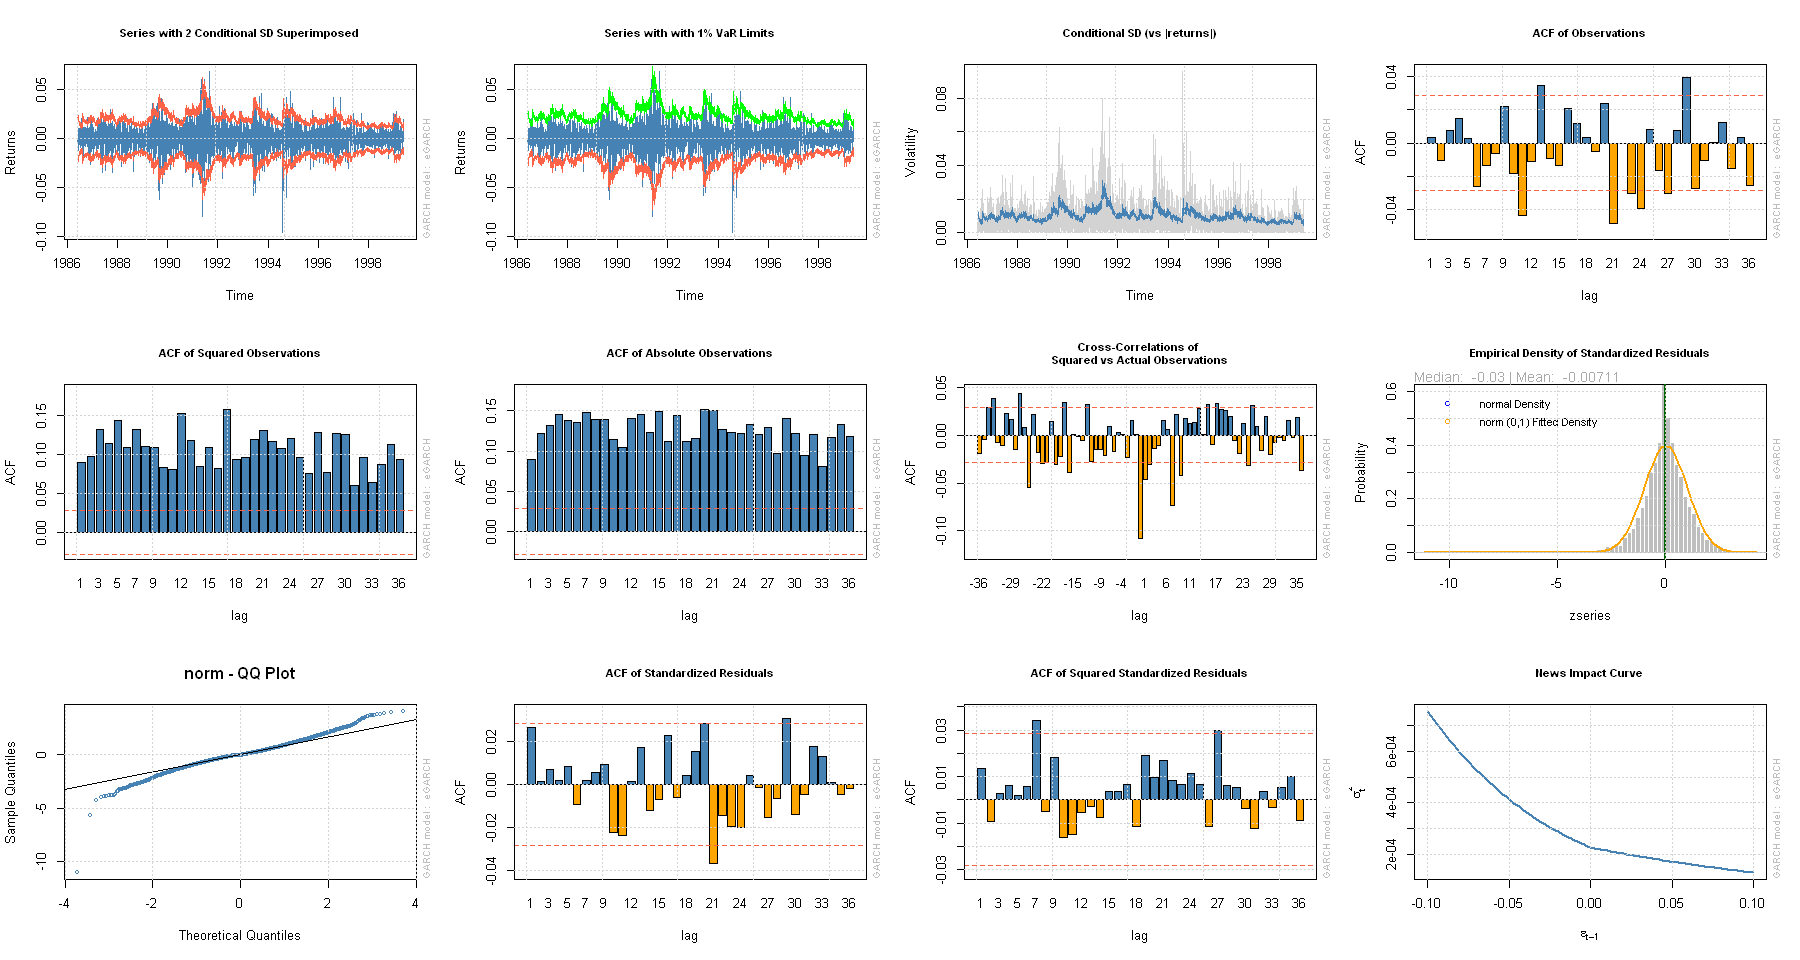

In [46]:
plot(gold_egarch21, which = 'all') 

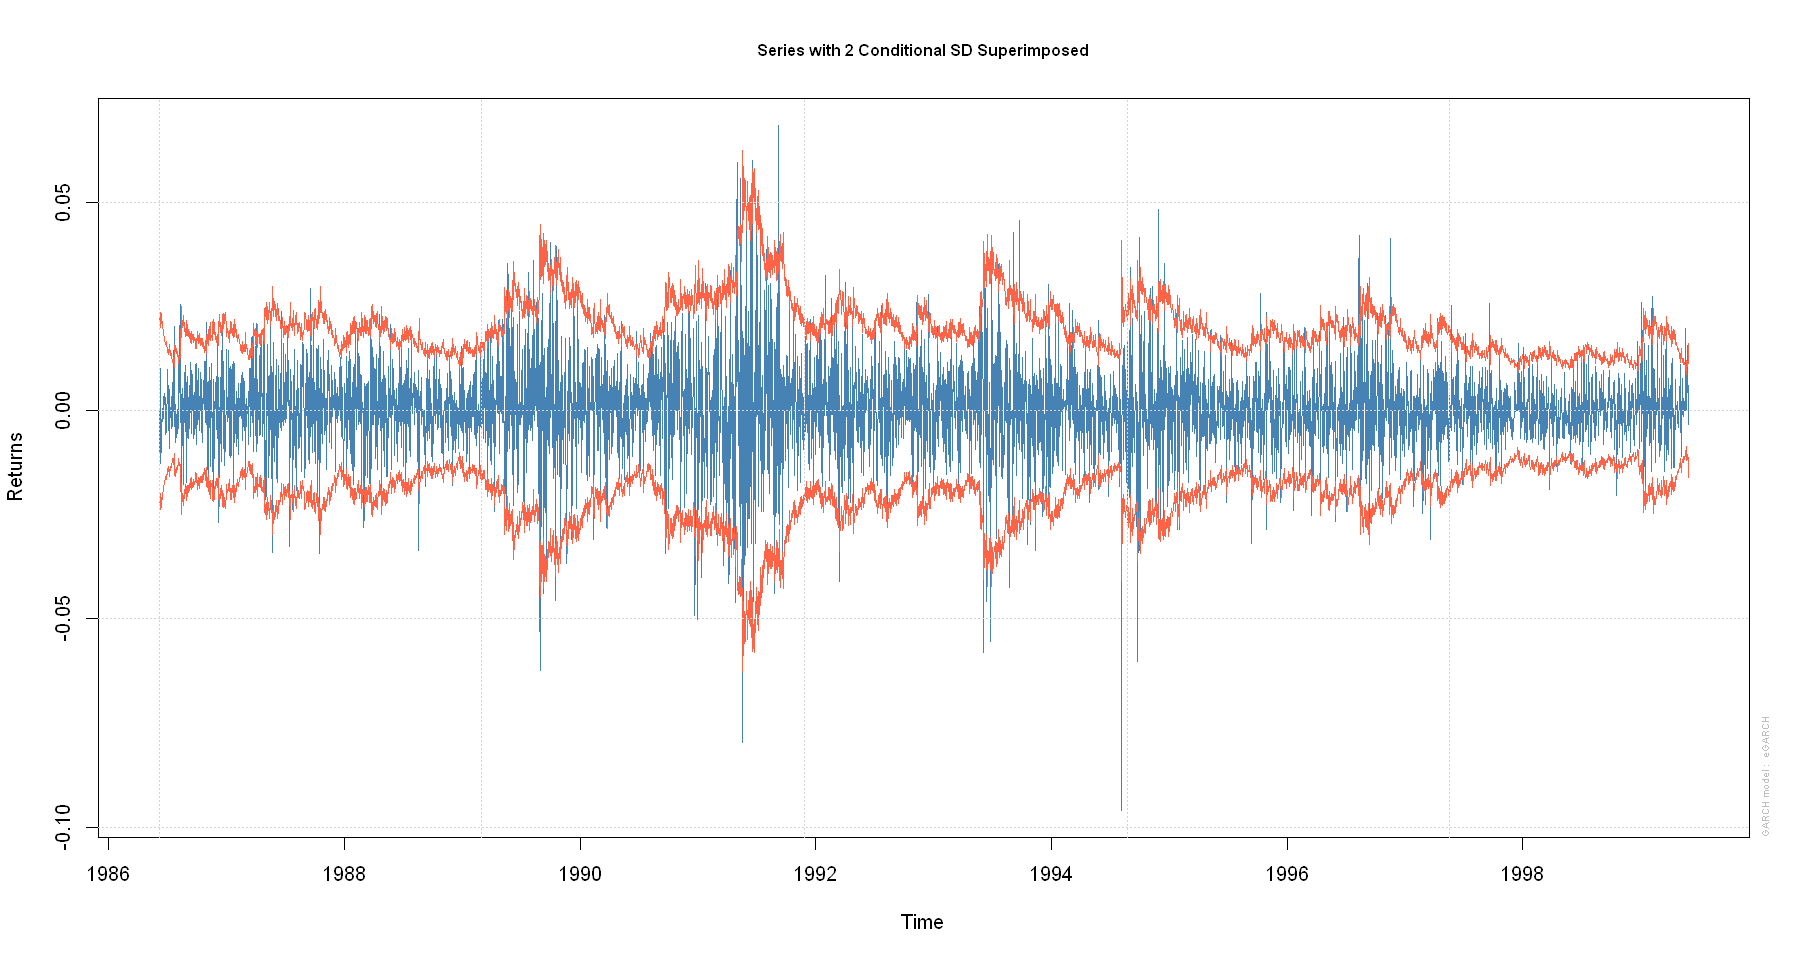

In [47]:
plot(gold_egarch21, which = 1) 

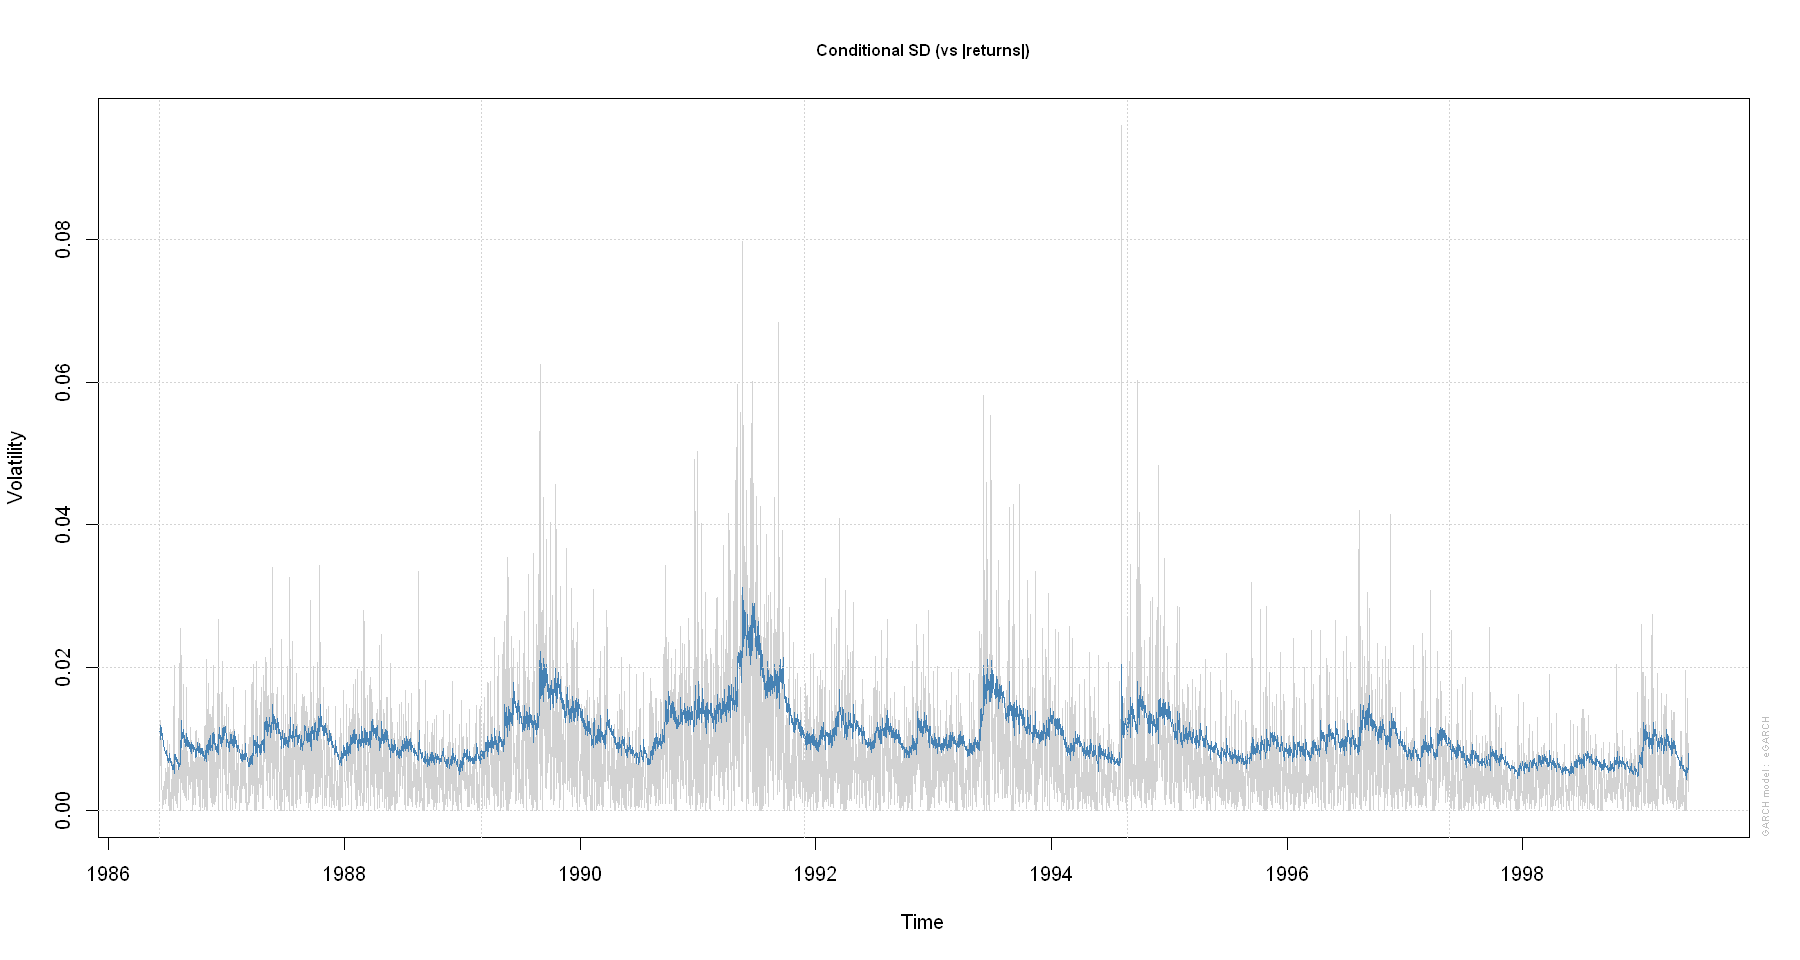

In [48]:
plot(gold_egarch21, which = 3) 

# Prediccion con nuestro mejor modelo EGARCH

In [49]:
predict_gold = ugarchforecast(gold_egarch21,n.ahead = 50)
predict_gold


*------------------------------------*
*       GARCH Model Forecast         *
*------------------------------------*
Model: eGARCH
Horizon: 50
Roll Steps: 0
Out of Sample: 0

0-roll forecast [T0=1999-05-29]:
        Series    Sigma
T+1  0.0004629 0.007400
T+2  0.0004629 0.007497
T+3  0.0004629 0.007538
T+4  0.0004629 0.007578
T+5  0.0004629 0.007618
T+6  0.0004629 0.007659
T+7  0.0004629 0.007699
T+8  0.0004629 0.007739
T+9  0.0004629 0.007779
T+10 0.0004629 0.007818
T+11 0.0004629 0.007858
T+12 0.0004629 0.007898
T+13 0.0004629 0.007937
T+14 0.0004629 0.007977
T+15 0.0004629 0.008016
T+16 0.0004629 0.008055
T+17 0.0004629 0.008094
T+18 0.0004629 0.008133
T+19 0.0004629 0.008172
T+20 0.0004629 0.008211
T+21 0.0004629 0.008250
T+22 0.0004629 0.008288
T+23 0.0004629 0.008327
T+24 0.0004629 0.008365
T+25 0.0004629 0.008404
T+26 0.0004629 0.008442
T+27 0.0004629 0.008480
T+28 0.0004629 0.008518
T+29 0.0004629 0.008555
T+30 0.0004629 0.008593
T+31 0.0004629 0.008631
T+32 0.0004629 0.008668

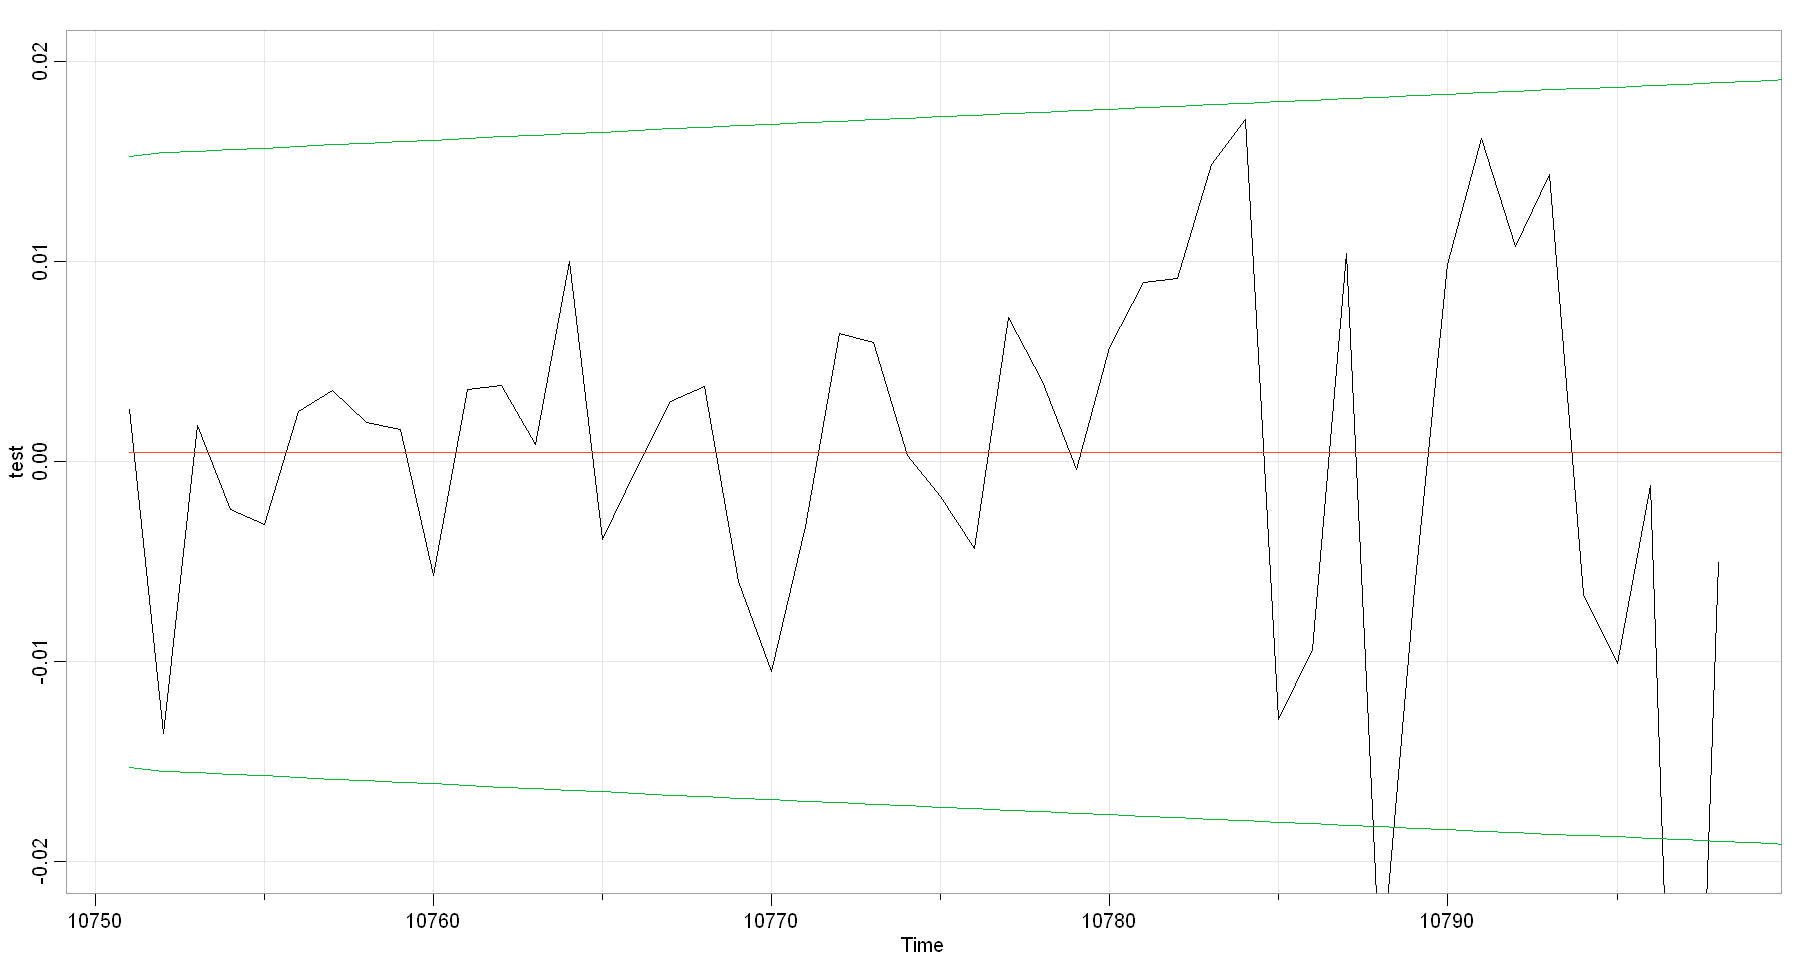

In [50]:
tsplot(test,ylim = c(-0.02,0.02))
lines(ts(predict_gold@forecast$seriesFor,start = 10751),col=2)
lines(ts(predict_gold@forecast$seriesFor + 2*predict_gold@forecast$sigmaFor,start = 10751),col=3)
lines(-ts(predict_gold@forecast$seriesFor + 2*predict_gold@forecast$sigmaFor,start = 10751),col=3)

#  Expected Shortfall

FALTA: Explicar expected SHortfall

In [51]:
sigma = predict_gold@forecast$sigmaFor
length(sigma)

[1] 50

In [52]:
alpha = 0.10

In [53]:
ES_01 = ''
VaR_01 = ''

for (i in 1:length(sigma)){
    ES_01[i] = -dnorm(qnorm(alpha)) / alpha * sigma[i]
    VaR_01[i]   = qnorm(alpha) * sigma[i]
    }
    

In [54]:
alpha = 0.01

In [55]:
ES_0.01 = ''
VaR_0.01 = ''

for (i in 1:length(sigma)){
    ES_0.01[i] = -dnorm(qnorm(alpha)) / alpha * sigma[i]
    VaR_0.01[i]   = qnorm(alpha) * sigma[i]
    }
    

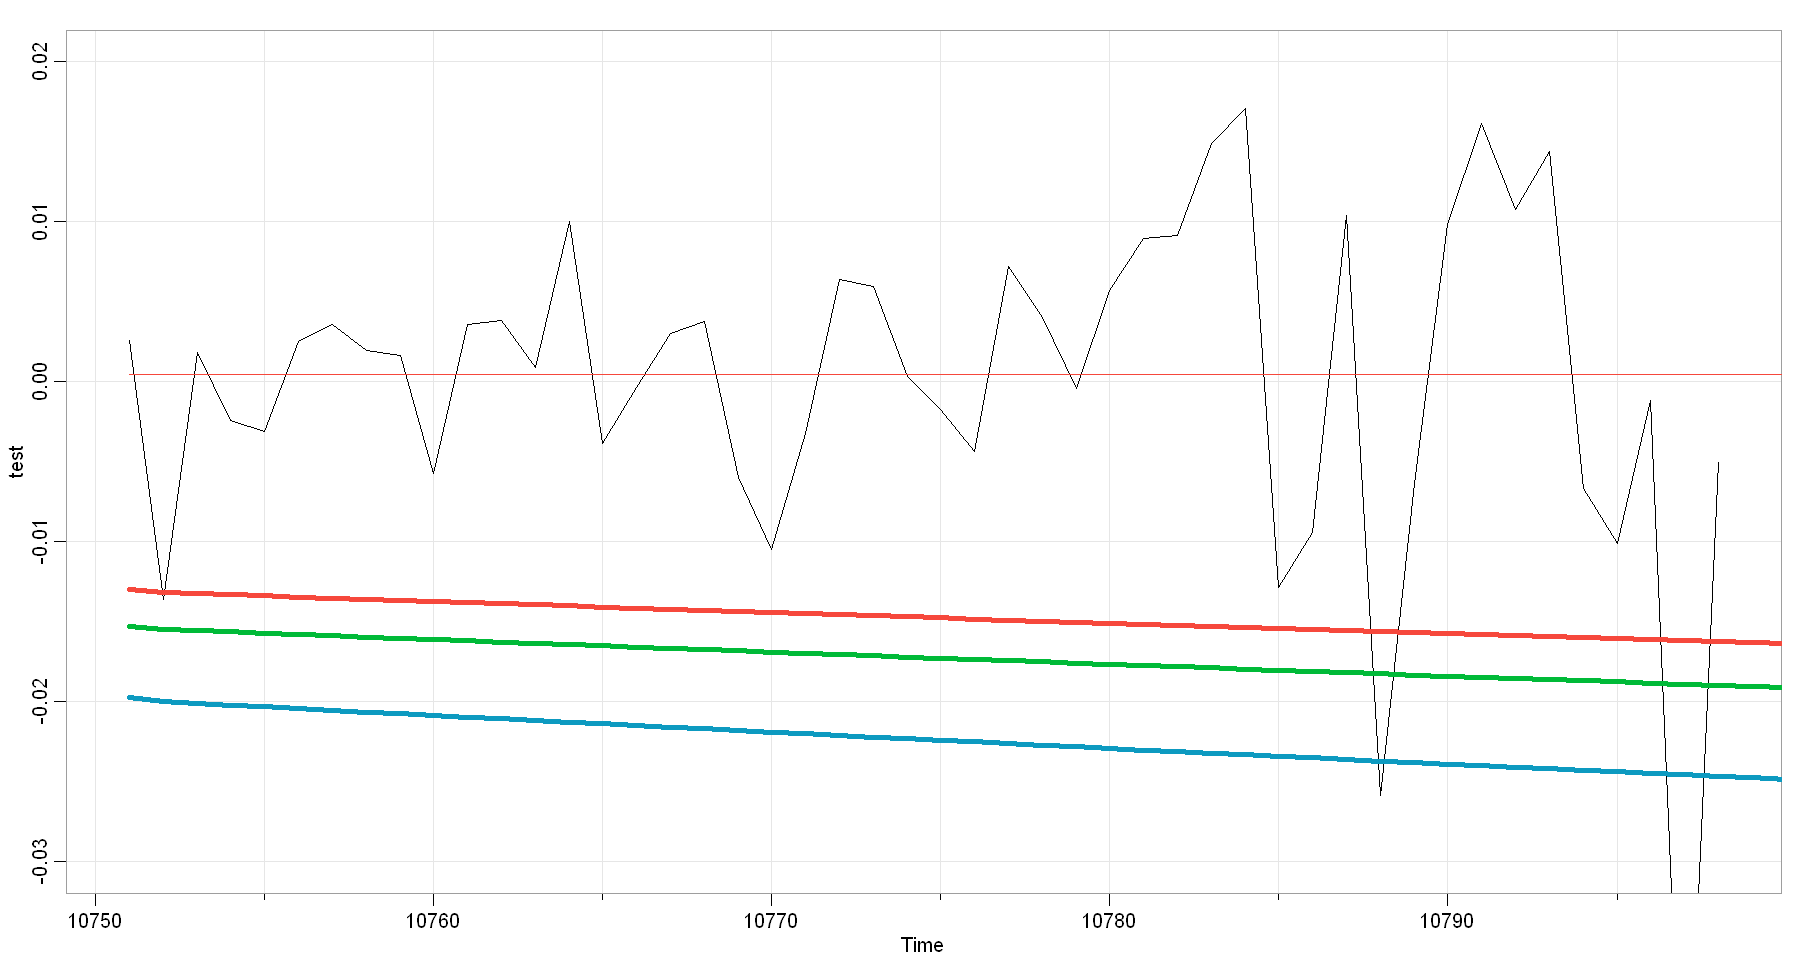

In [56]:
tsplot(test,ylim = c(-0.03,0.02))
lines(ts(predict_gold@forecast$seriesFor,start = 10751),col=2)
lines(-ts(predict_gold@forecast$seriesFor + 2*predict_gold@forecast$sigmaFor,start = 10751),col=3,lwd = 4) #Verde
lines(ts(ES_01,start = 10751),col=2,lwd = 4) #Rojo
lines(ts(ES_0.01,start = 10751),col=5,lwd = 4) #azul
#lines(ts(VaR,start = 10751),col=5,lwd = 4)

In [57]:
print(paste0(test[2]*100," %"))

[1] "-1.35782020143074 %"


In [58]:
ES_01[2]

[1] "-0.0131575546864016"

In [59]:
length(test)

[1] 48

FALTA: Explicar lo que sale de expected SHortfall